# Let's looks for correlations beetween places ocupacy and infected cases
## Huge work in progress, please don't take this investigation too seriusly yet, is highly exprorative

 - Mobility data [from google](https://www.google.com/covid19/mobility/), and was [ripped here](https://github.com/verasativa/covi-19-chile/blob/master/Google-community-mobility-report-extrator/gcmr.csv).
 - Infections in Chile data from [Allkun Analitica's datastudio](https://datastudio.google.com/u/0/reporting/1oTmHXjhKFfvmetVm7ktujAlZAPLYCiac/page/iFHJB) dashboard.

## Data cooking

In [1]:
#Cargamos datos de infecciones
import pandas as pd

colmap = {
    'Evolución acumulada de casos': 'total_cases',
    'Evolución de nuevos casos': 'new_cases'
}
idf = pd.read_csv('covid19_cl_Resumen Allkun Analítica_Gráfico combinado.csv').rename(columns=colmap)

# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    base_date = datetime.datetime(2020, 3, 2)
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


idf['ds'] = pd.Series(idf.index).apply(nday2datetime)
idf.set_index('ds', inplace=True)

idf.head()

fechainiciosintoma  total_cases  new_cases
ds                                                   
2020-03-02        2 mar. 2020            1          1
2020-03-03        3 mar. 2020            1          1
2020-03-04        4 mar. 2020            2          2
2020-03-05        5 mar. 2020            2          2
2020-03-06        7 mar. 2020            1          1

In [2]:
# Cargamos mobilidad

mdf = pd.read_feather('Google-community-mobility-report-extrator/gcmr.feather')
mdf.set_index('date', inplace=True)
mdf.head()

Residential  Grocery & pharmacy     Parks  Retail - recreation  \
date                                                                         
2020-02-16     0.000000            0.050146  0.047114             0.032653   
2020-02-17     0.008163            0.055044  0.109155             0.009096   
2020-02-18     0.009563            0.050612  0.125015             0.002332   
2020-02-19     0.009563            0.075569  0.108455            -0.003265   
2020-02-20     0.009796            0.051312  0.114286            -0.014927   

            Workplaces  Transit stations  
date                                      
2020-02-16   -0.005831          0.042682  
2020-02-17   -0.076968         -0.030787  
2020-02-18   -0.068105         -0.026822  
2020-02-19   -0.066006         -0.031020  
2020-02-20   -0.067405         -0.027522

In [3]:
import datetime

deltas = []
for i in range(3, 16):
    delta = datetime.timedelta(days=i)
    deltas.append(delta)
#deltas

In [9]:
def add_mobility(row):
    for delta in deltas:
        for place, rate in mdf.loc[row.name.date() - delta].items():
            row[f'{place} day -{delta.days:02}'] = rate
        
    return row
    
idf.sample(n=3).apply(add_mobility, axis=1)

fechainiciosintoma  total_cases  new_cases  Residential day -03  \
ds                                                                           
2020-03-02        2 mar. 2020            1          1             0.010029   
2020-03-26       29 mar. 2020          230        230             0.243265   
2020-03-24       27 mar. 2020          304        304             0.220408   

            Grocery & pharmacy day -03  Parks day -03  \
ds                                                      
2020-03-02                    0.085364      -0.024490   
2020-03-26                   -0.377143      -0.605015   
2020-03-24                   -0.314402      -0.659825   

            Retail - recreation day -03  Workplaces day -03  \
ds                                                            
2020-03-02                     0.058076            0.021458   
2020-03-26                    -0.624140           -0.405131   
2020-03-24                    -0.629038           -0.323032   

            Transit stations day -03  Residential day -04  ...  Parks day -14  \
ds                                                         ...                  
2020-03-02                  0.001866             0.015627  ...       0.109155   
2020-03-26                 -0.558834             0.222974  ...      -0.212245   
2020-03-24                 -0.504956             0.225773  ...      -0.170962   

            Retail - recreation day -14  Workplaces day -14  \
ds                                                            
2020-03-02                     0.009096           -0.076968   
2020-03-26                    -0.071137            0.168397   
2020-03-24                    -0.025423            0.173061   

            Transit stations day -14  Residential day -15  \
ds                                                          
2020-03-02                 -0.030787             0.000000   
2020-03-26                  0.053178            -0.001866   
2020-03-24                  0.069271            -0.004665   

            Grocery & pharmacy day -15  Parks day -15  \
ds                                                      
2020-03-02                    0.050146       0.047114   
2020-03-26                   -0.004665      -0.191254   
2020-03-24                    0.020991      -0.134111   

            Retail - recreation day -15  Workplaces day -15  \
ds                                                            
2020-03-02                     0.032653           -0.005831   
2020-03-26                    -0.083732            0.164898   
2020-03-24                    -0.031720            0.164198   

            Transit stations day -15  
ds                                    
2020-03-02                  0.042682  
2020-03-26                  0.061808  
2020-03-24                  0.045015  

[3 rows x 81 columns]

# Kind of works, let's try to regress it

In [10]:
df = idf.apply(add_mobility, axis=1).drop(columns=['fechainiciosintoma'])
df['_count'] = df.reset_index().index.values
df = df.reindex(sorted(df.columns), axis=1)

df.head()

Grocery & pharmacy day -03  Grocery & pharmacy day -04  \
ds                                                                   
2020-03-02                    0.085364                    0.031020   
2020-03-03                    0.120816                    0.085364   
2020-03-04                    0.153936                    0.120816   
2020-03-05                    0.089096                    0.153936   
2020-03-06                    0.100292                    0.089096   

            Grocery & pharmacy day -05  Grocery & pharmacy day -06  \
ds                                                                   
2020-03-02                    0.028455                    0.032187   
2020-03-03                    0.031020                    0.028455   
2020-03-04                    0.085364                    0.031020   
2020-03-05                    0.120816                    0.085364   
2020-03-06                    0.153936                    0.120816   

            Grocery & pharmacy day -07  Grocery & pharmacy day -08  \
ds                                                                   
2020-03-02                    0.027988                    0.043382   
2020-03-03                    0.032187                    0.027988   
2020-03-04                    0.028455                    0.032187   
2020-03-05                    0.031020                    0.028455   
2020-03-06                    0.085364                    0.031020   

            Grocery & pharmacy day -09  Grocery & pharmacy day -10  \
ds                                                                   
2020-03-02                    0.046647                    0.050146   
2020-03-03                    0.043382                    0.046647   
2020-03-04                    0.027988                    0.043382   
2020-03-05                    0.032187                    0.027988   
2020-03-06                    0.028455                    0.032187   

            Grocery & pharmacy day -11  Grocery & pharmacy day -12  ...  \
ds                                                                  ...   
2020-03-02                    0.051312                    0.075569  ...   
2020-03-03                    0.050146                    0.051312  ...   
2020-03-04                    0.046647                    0.050146  ...   
2020-03-05                    0.043382                    0.046647  ...   
2020-03-06                    0.027988                    0.043382  ...   

            Workplaces day -09  Workplaces day -10  Workplaces day -11  \
ds                                                                       
2020-03-02           -0.021924           -0.070204           -0.067405   
2020-03-03           -0.017259           -0.021924           -0.070204   
2020-03-04           -0.023324           -0.017259           -0.021924   
2020-03-05           -0.010262           -0.023324           -0.017259   
2020-03-06            0.002099           -0.010262           -0.023324   

            Workplaces day -12  Workplaces day -13  Workplaces day -14  \
ds                                                                       
2020-03-02           -0.066006           -0.068105           -0.076968   
2020-03-03           -0.067405           -0.066006           -0.068105   
2020-03-04           -0.070204           -0.067405           -0.066006   
2020-03-05           -0.021924           -0.070204           -0.067405   
2020-03-06           -0.017259           -0.021924           -0.070204   

            Workplaces day -15  _count  new_cases  total_cases  
ds                                                              
2020-03-02           -0.005831       0          1            1  
2020-03-03           -0.076968       1          1            1  
2020-03-04           -0.068105       2          2            2  
2020-03-05           -0.066006       3          2            2  
2020-03-06           -0.067405       4          1            1  

[5 rows x 81 columns]

In [24]:
X = df[df.columns[:-2]].values
y = df.new_cases.values

In [25]:
y

array([  1,   1,   2,   2,   1,   2,  14,  10,  10,  17,  12,  83,  46,
        37, 104,  92, 103,  95, 114, 176, 220, 164, 304, 299, 230, 310,
       289, 293, 373, 333, 424])

In [41]:
from pygam import LinearGAM, s, f
import numpy as np

gam = LinearGAM()



lams = np.random.rand(1000, 79) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3
lams=np.logspace(-12, 12, 5000)
gam.gridsearch(X, y, lam=lams)

  0% (9 of 5000) |                       | Elapsed Time: 0:00:16 ETA:   2:20:11

LinAlgError: SVD did not converge

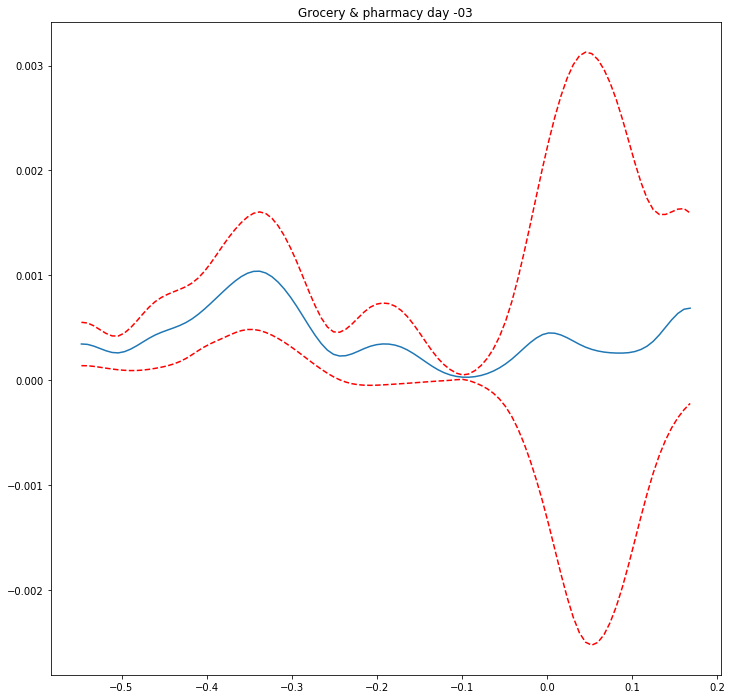

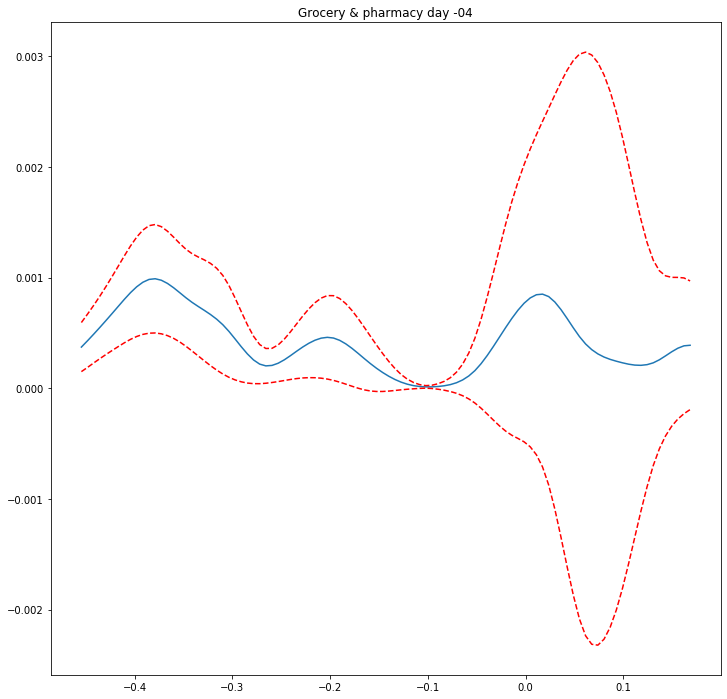

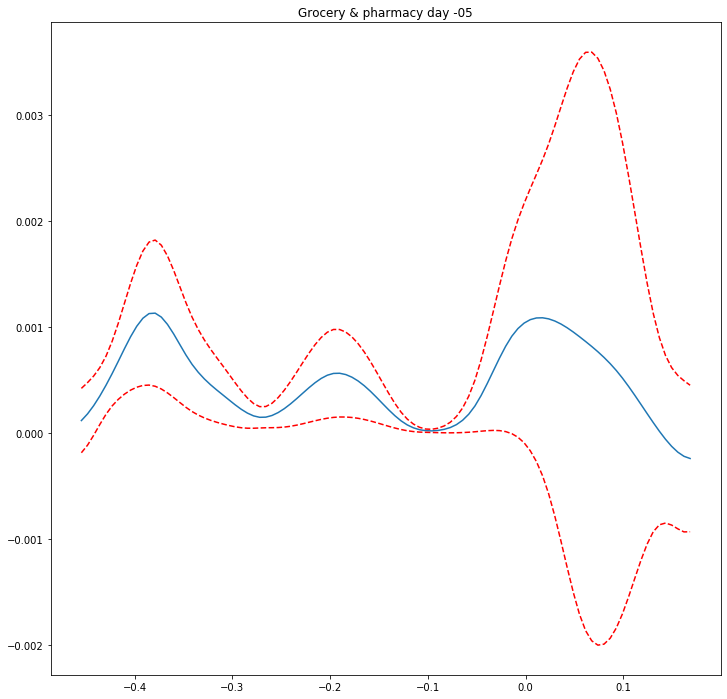

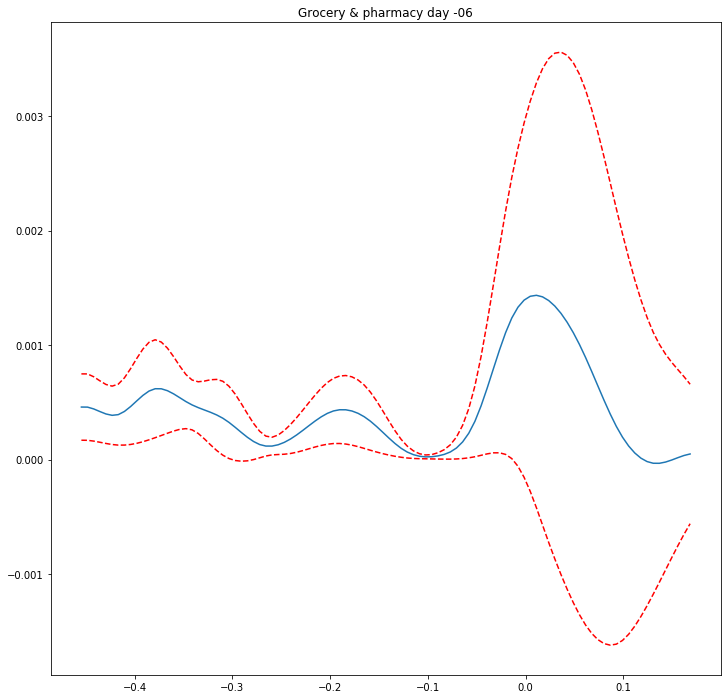

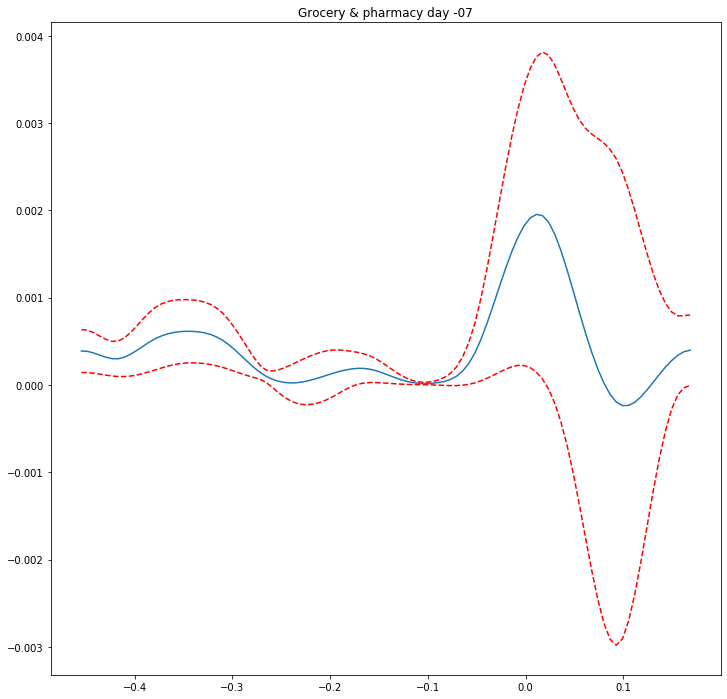

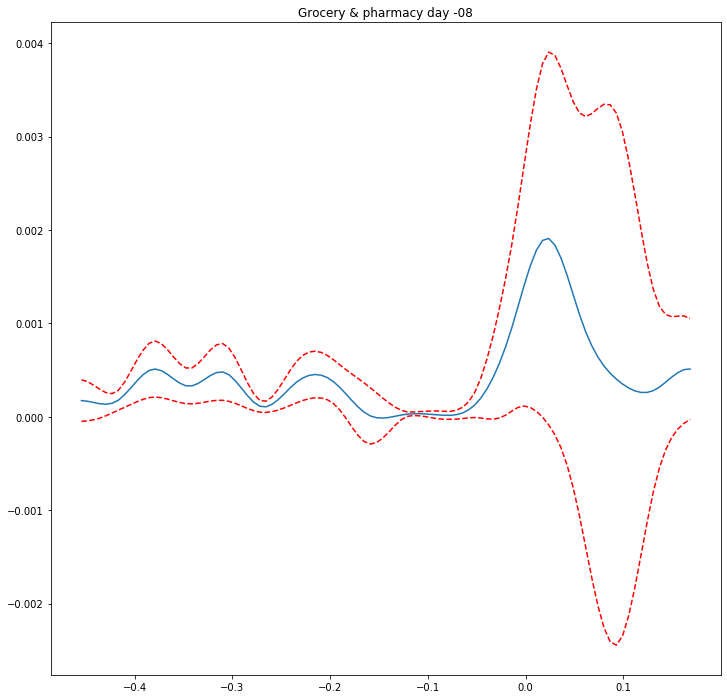

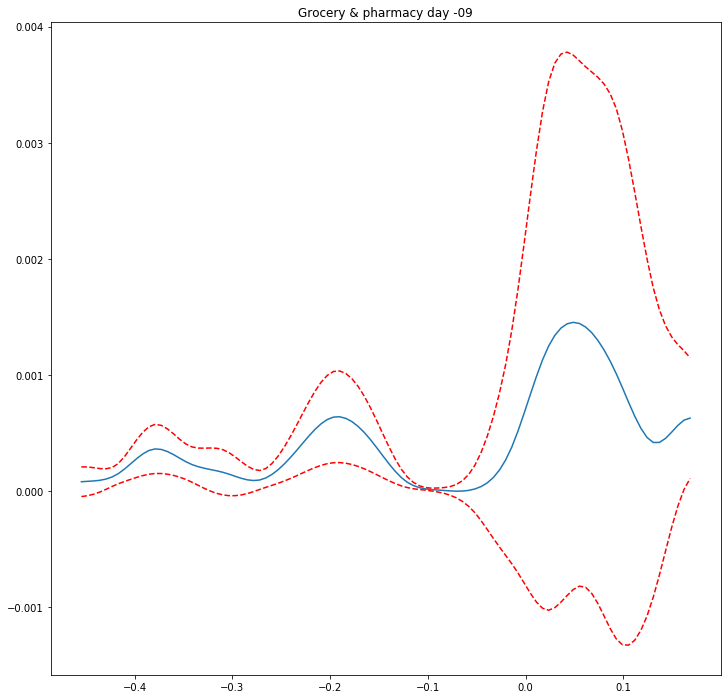

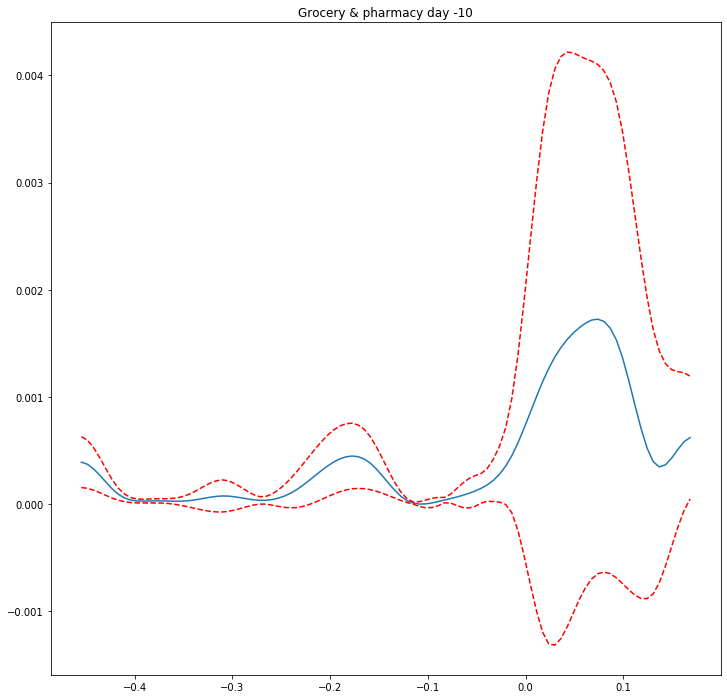

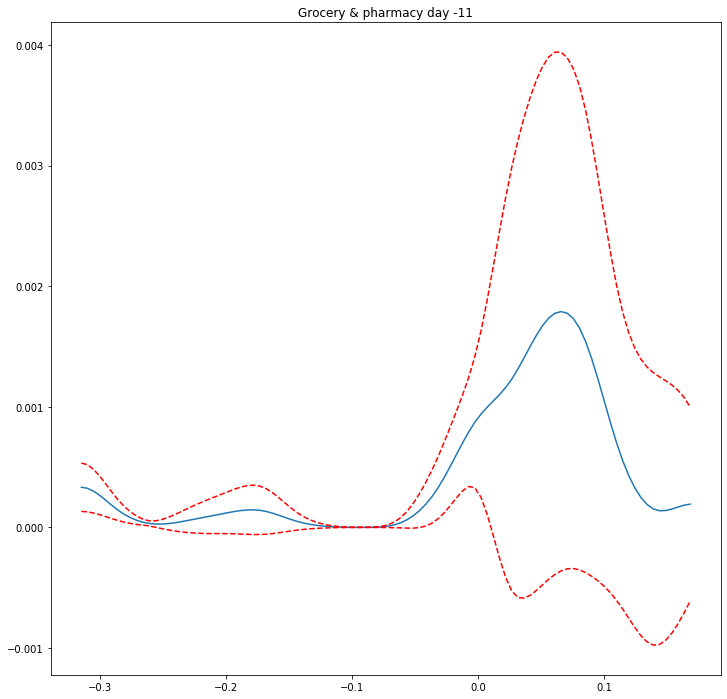

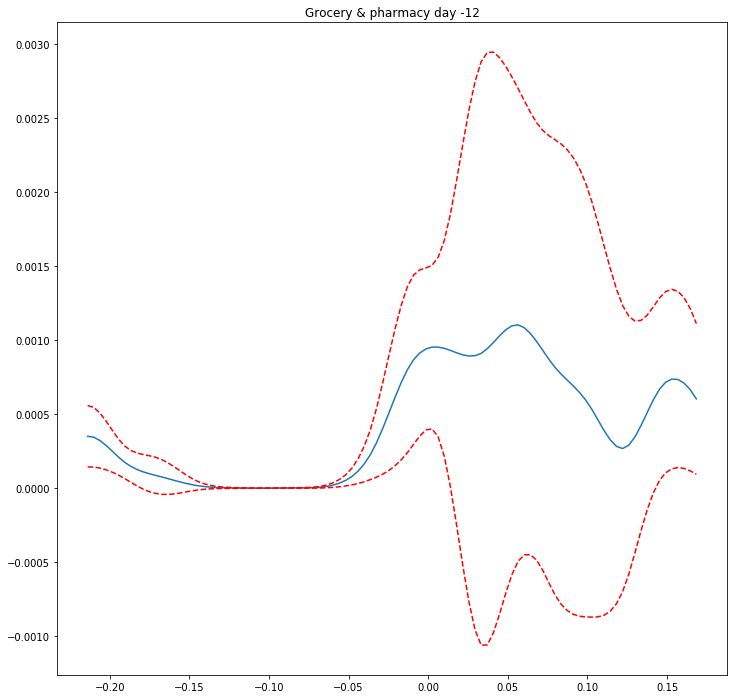

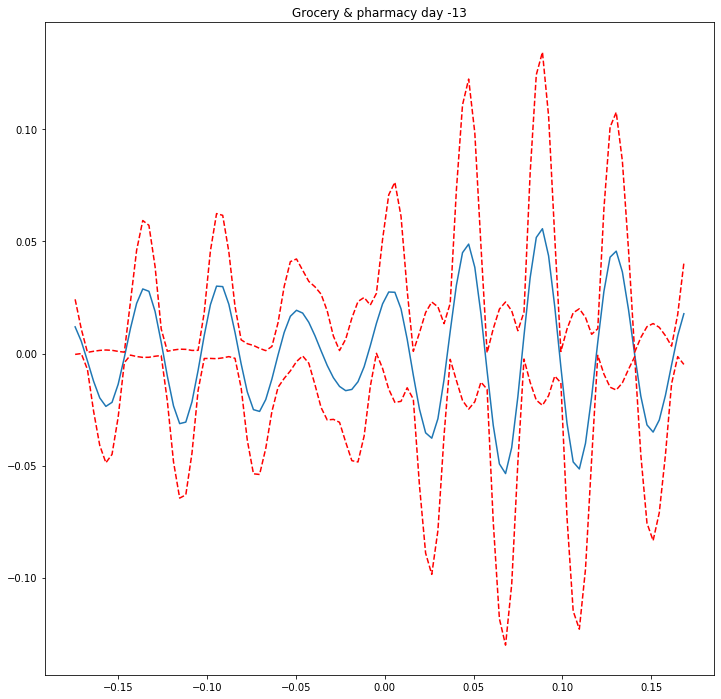

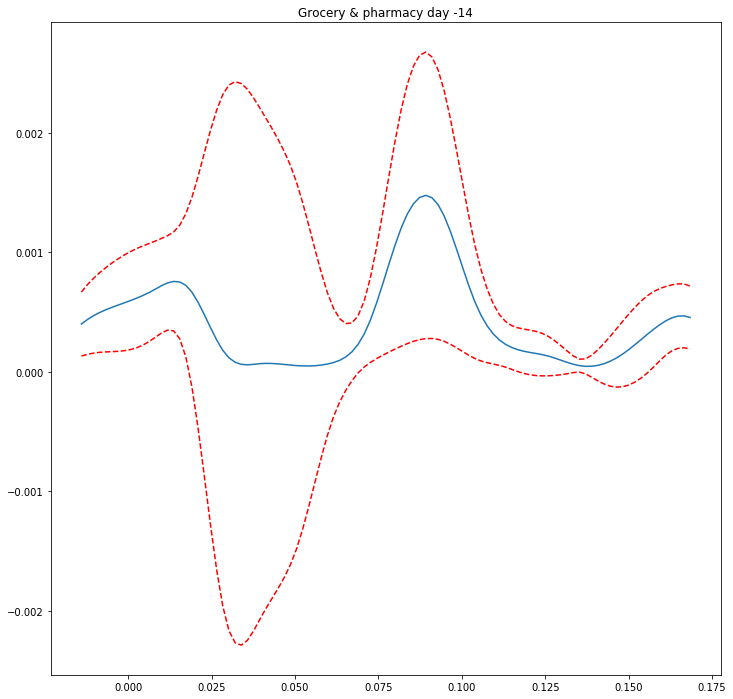

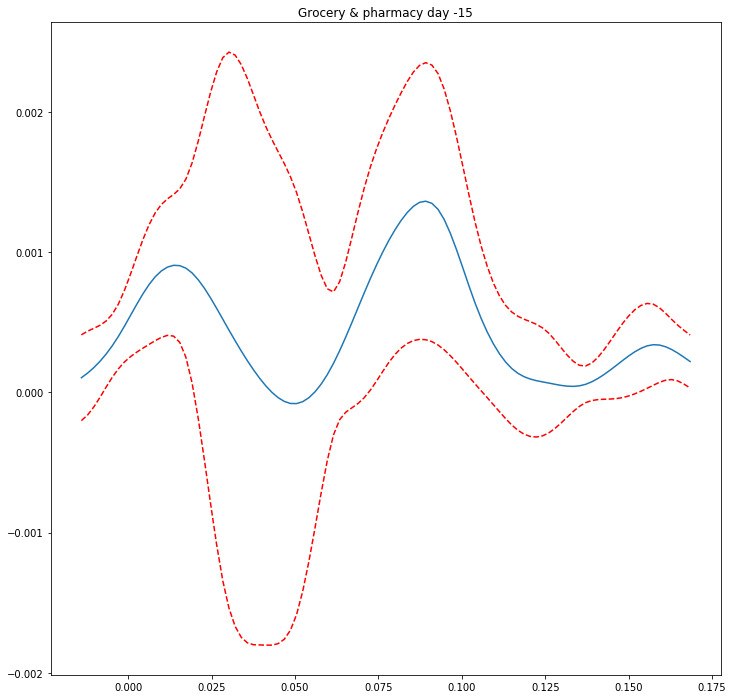

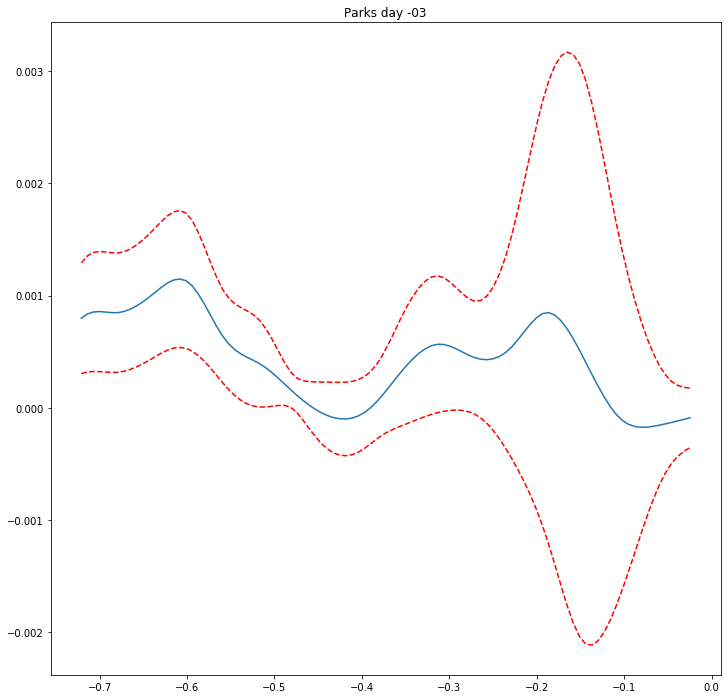

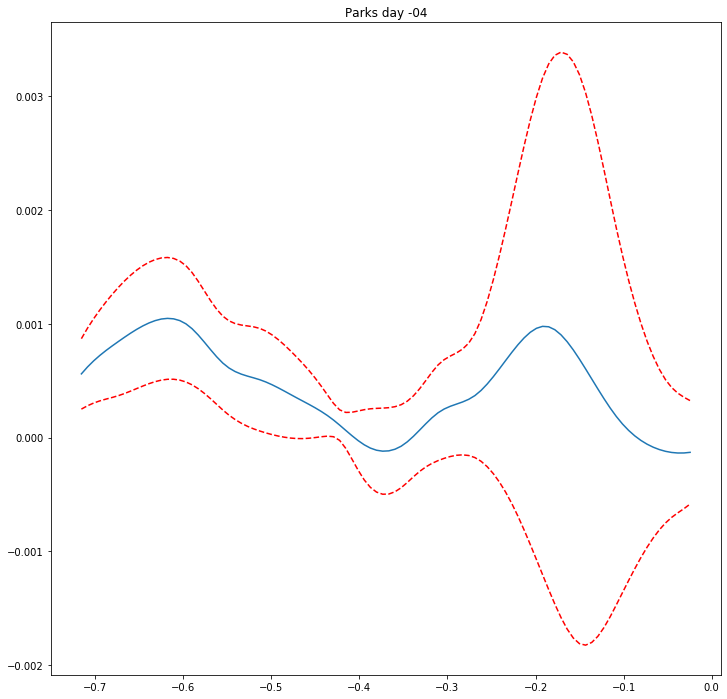

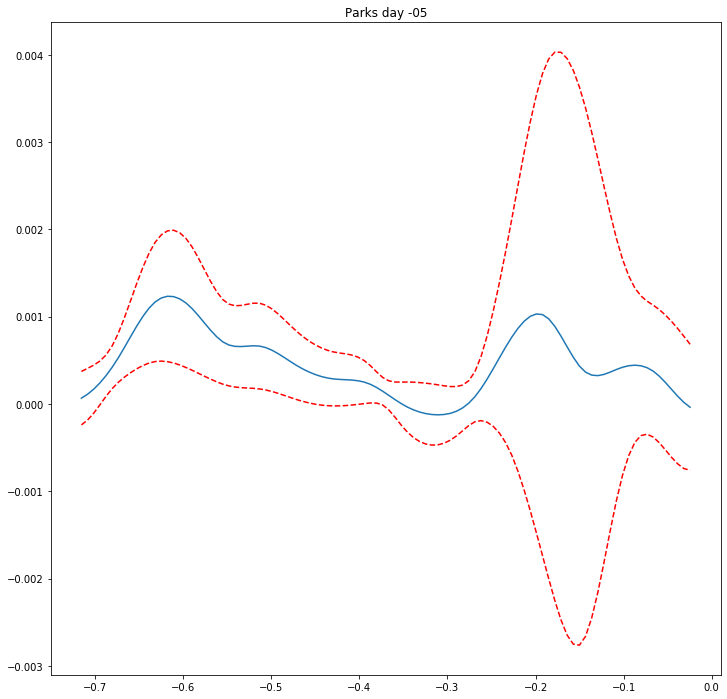

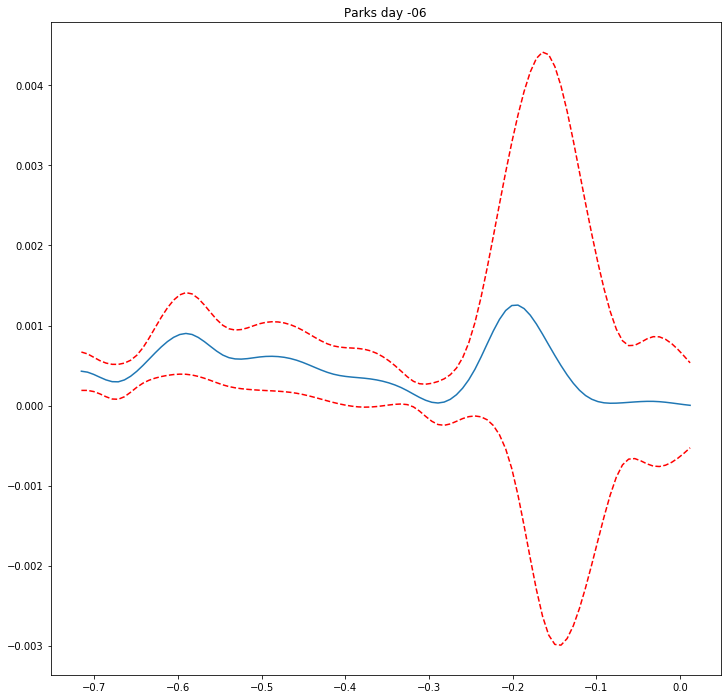

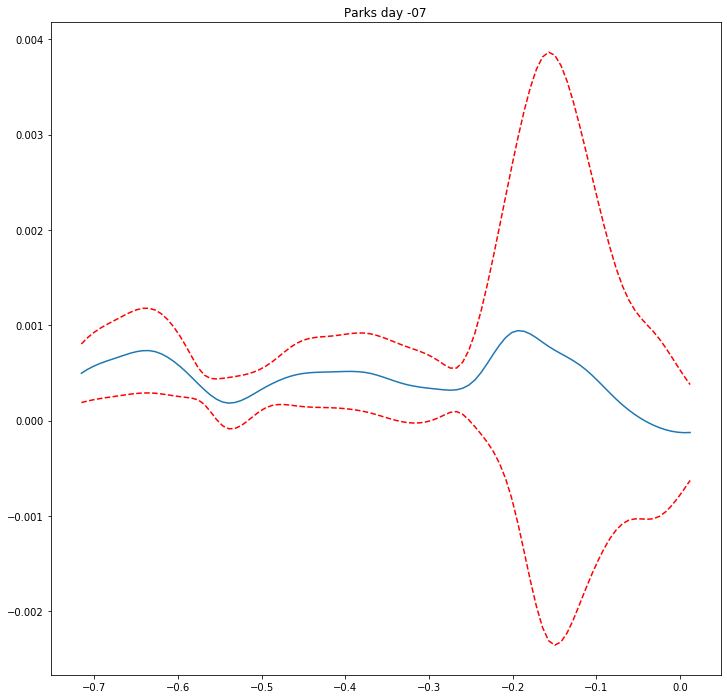

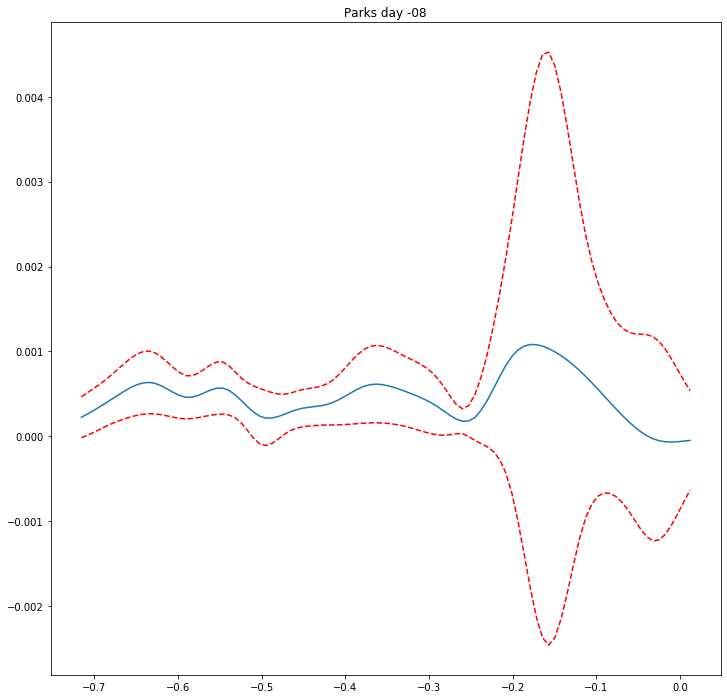

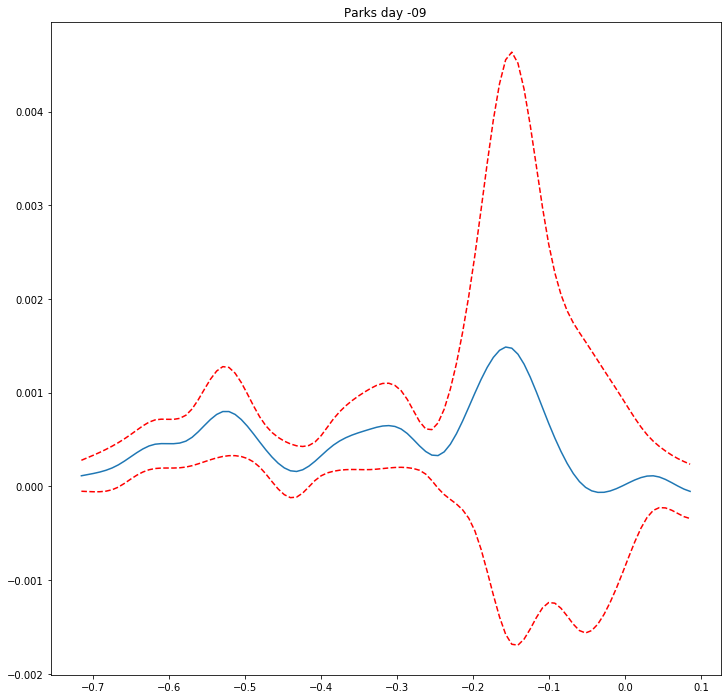

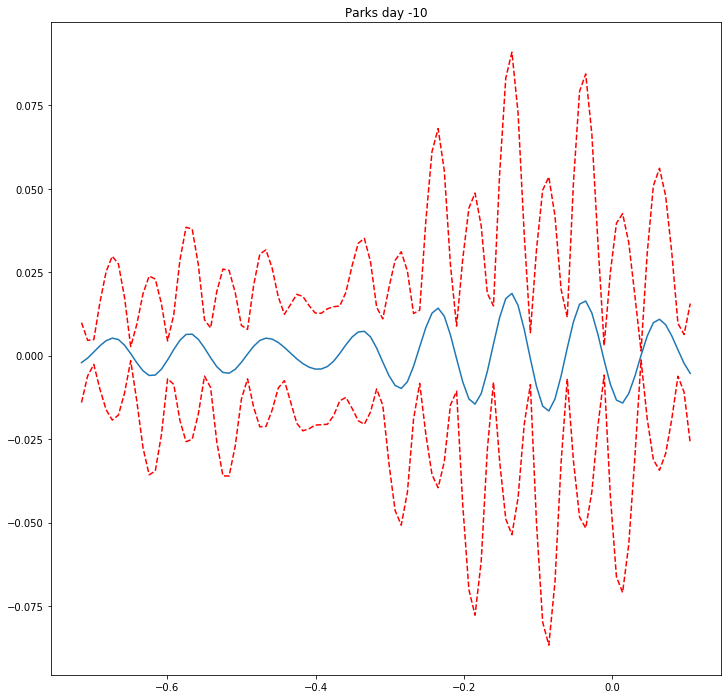

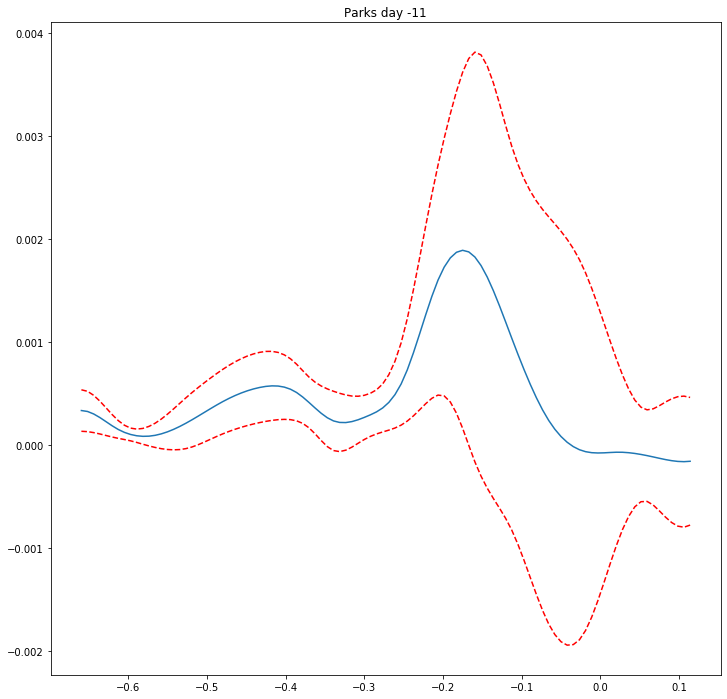

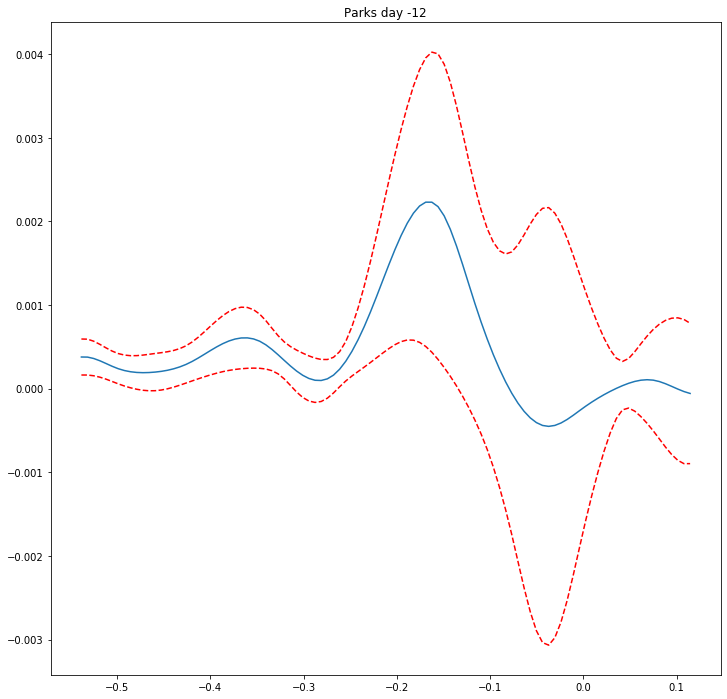

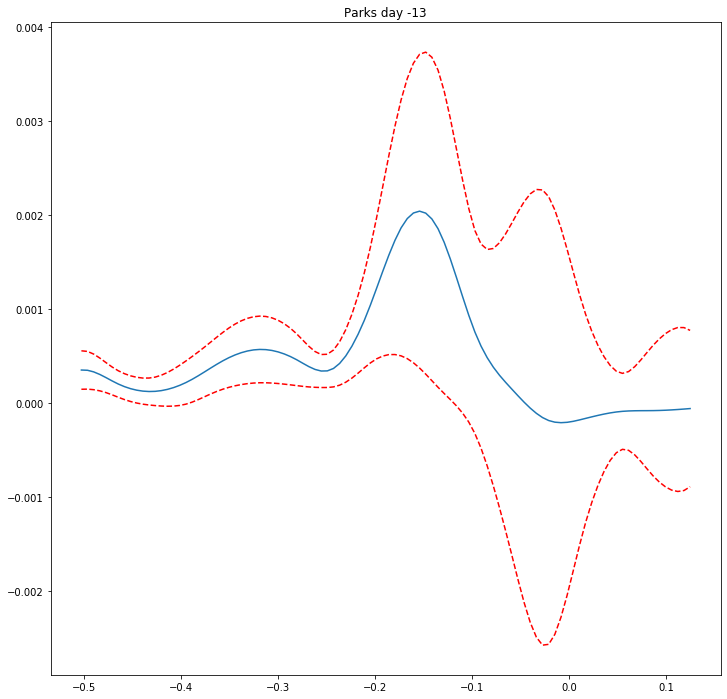

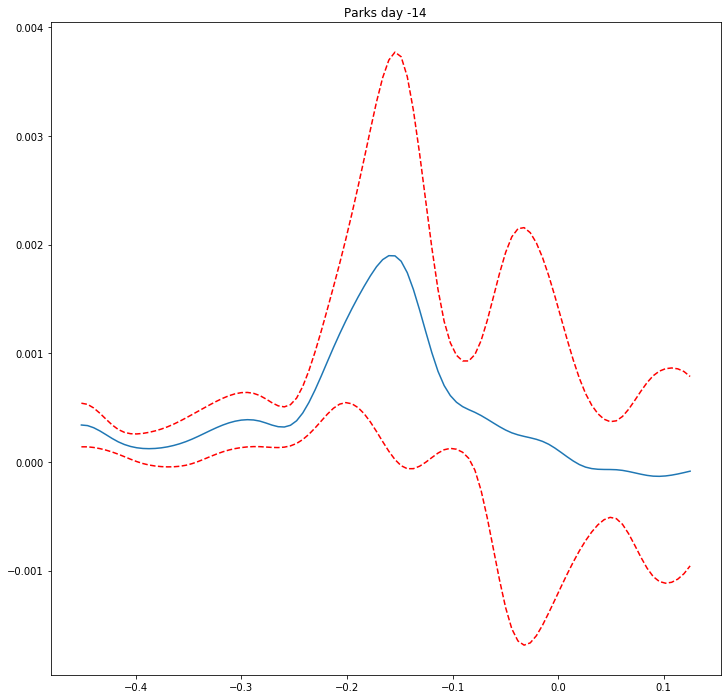

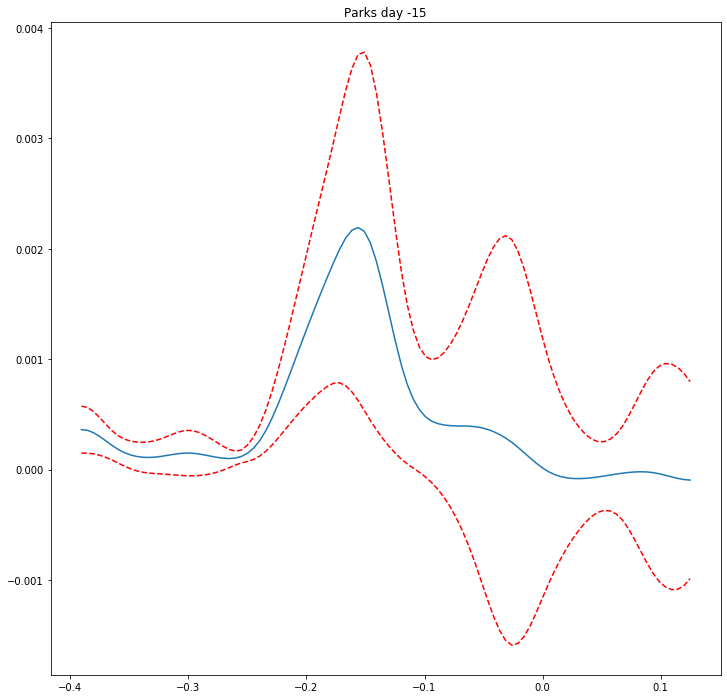

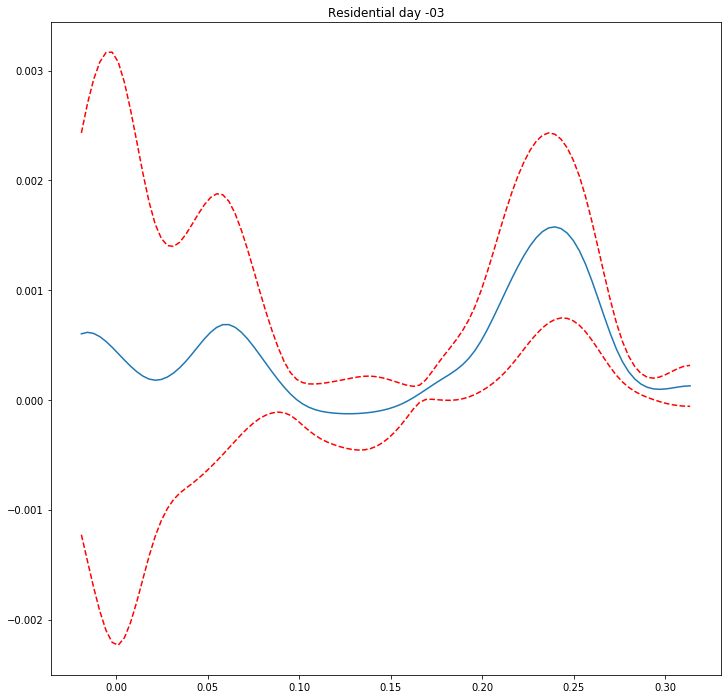

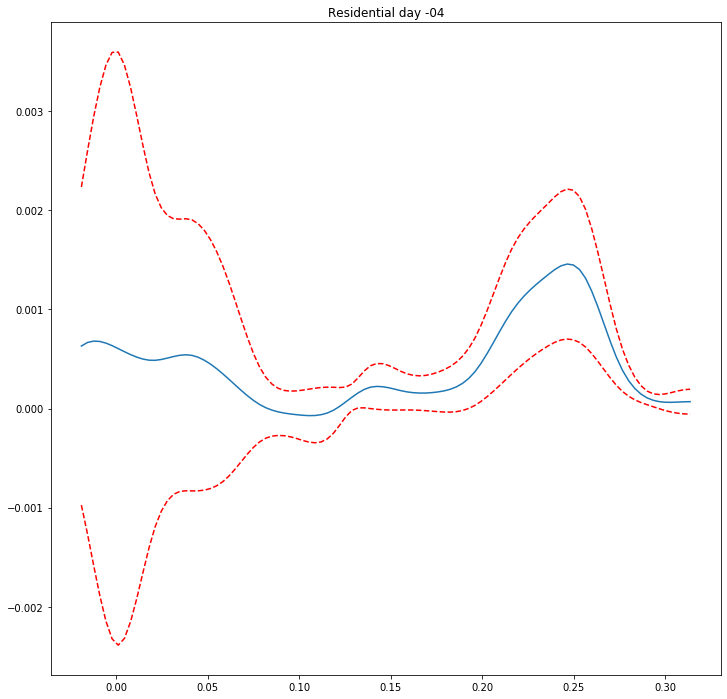

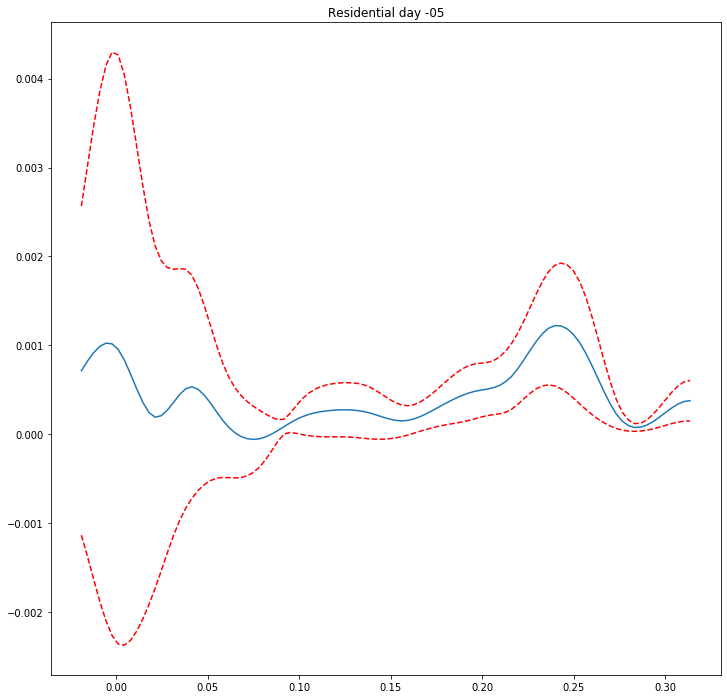

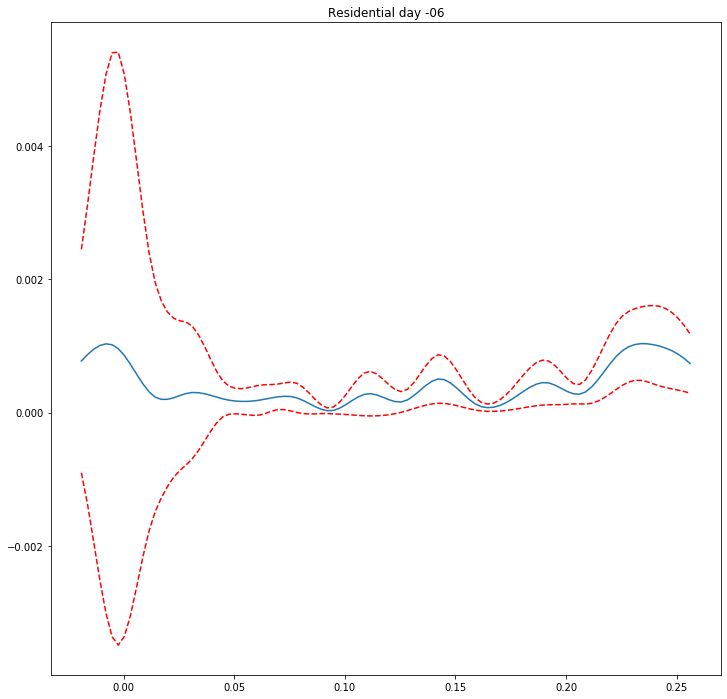

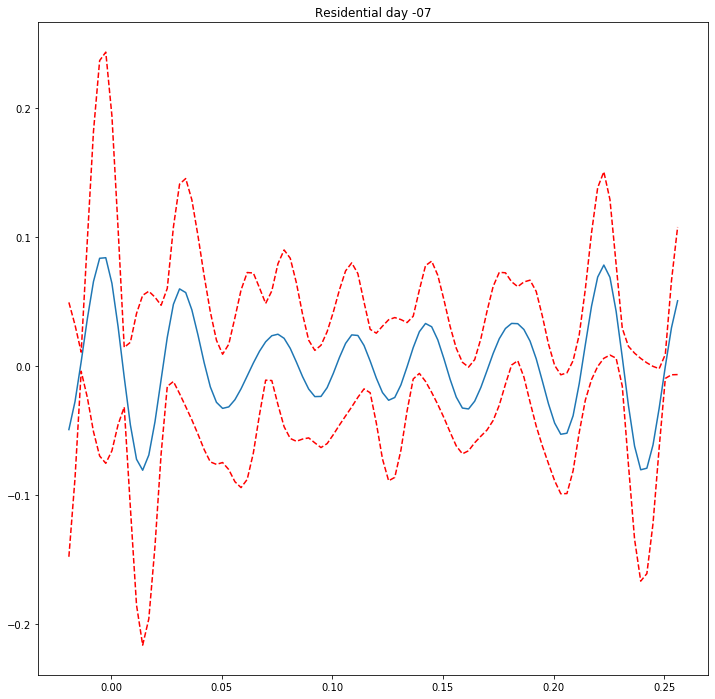

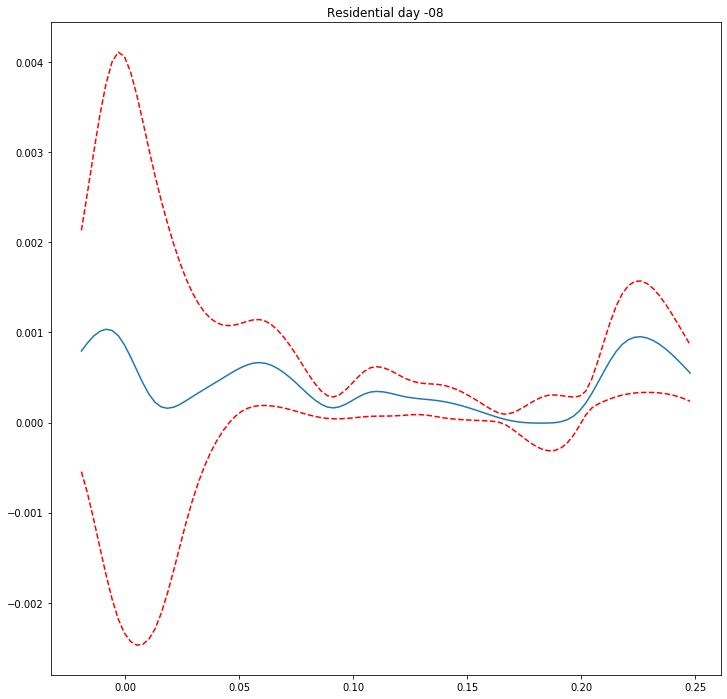

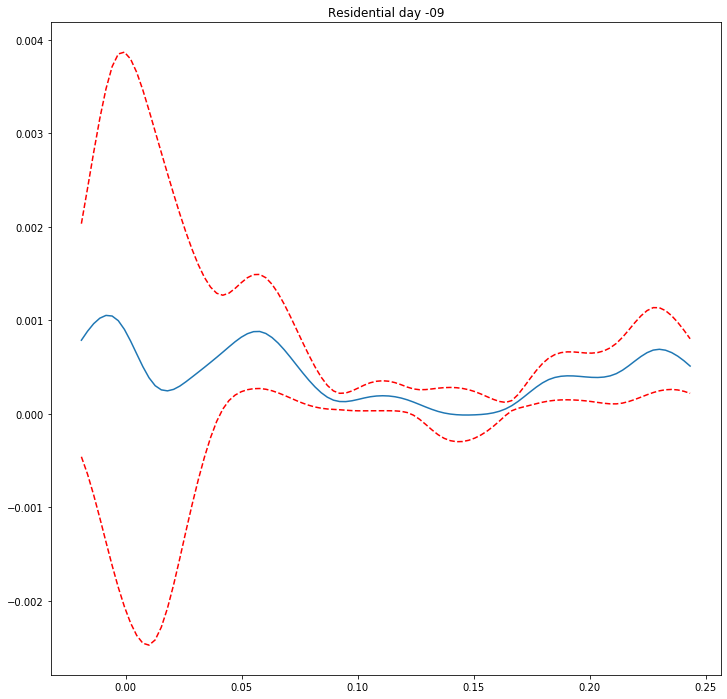

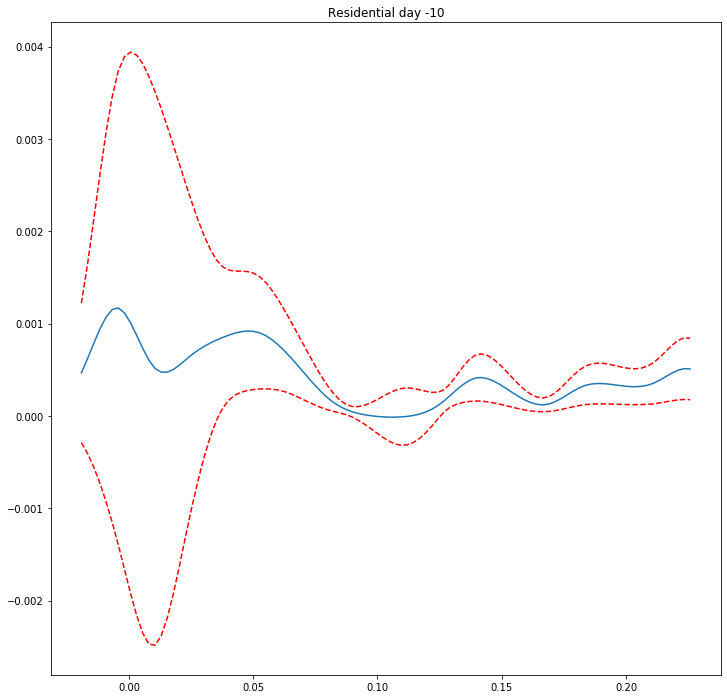

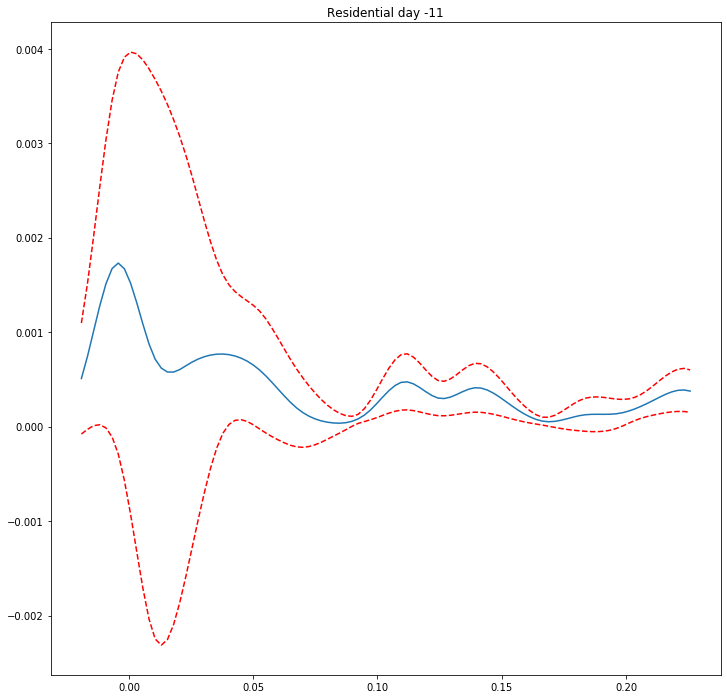

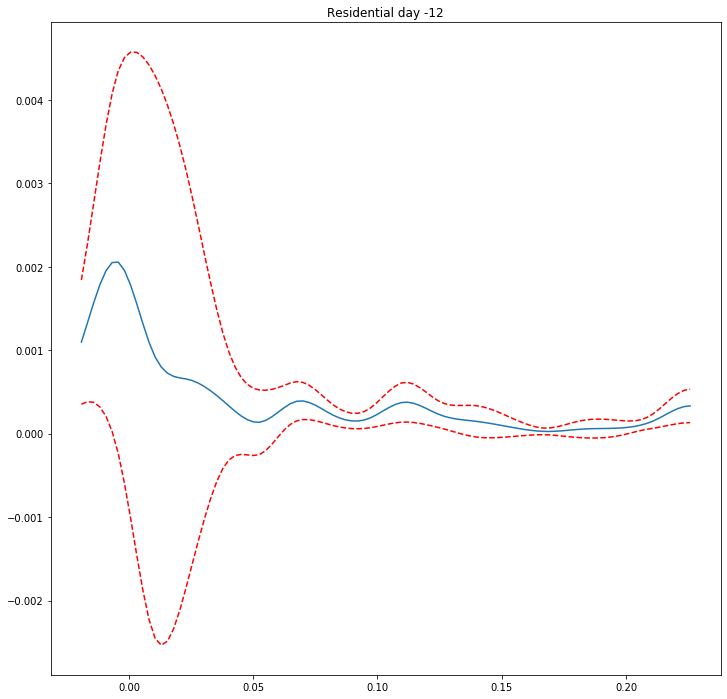

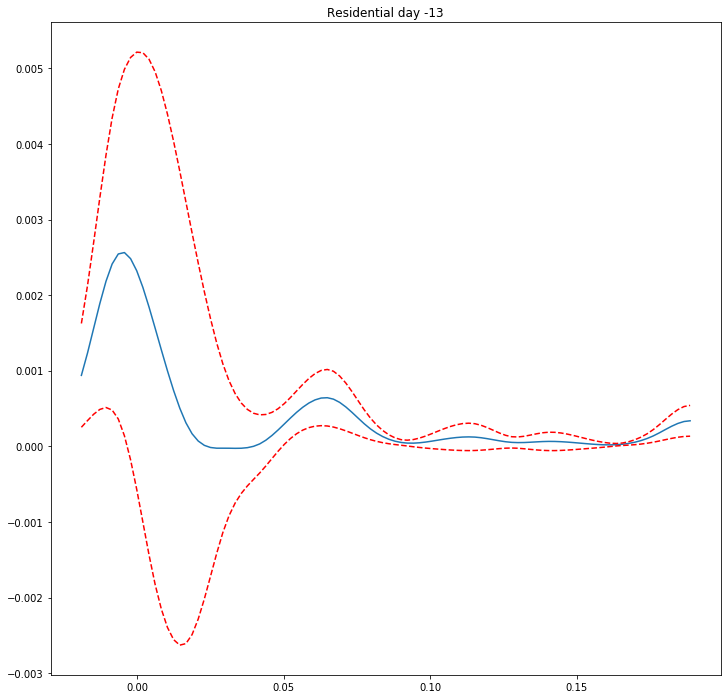

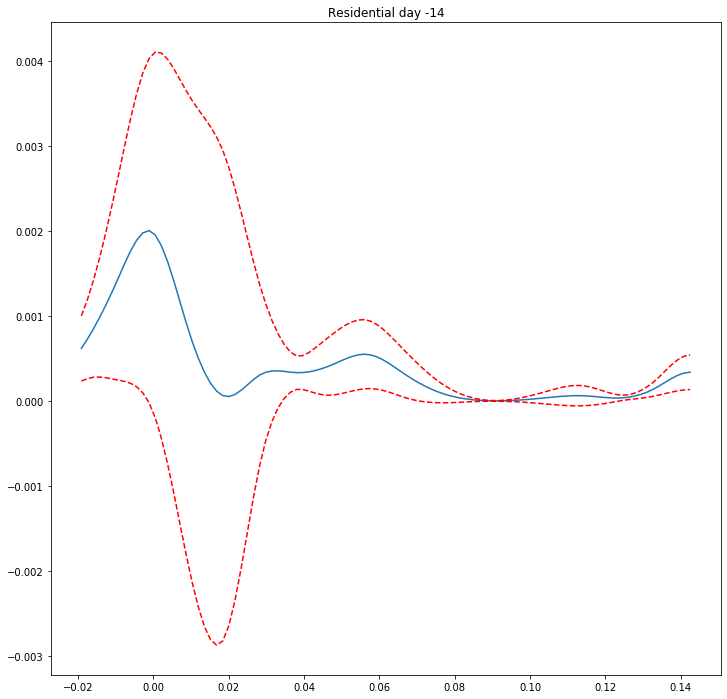

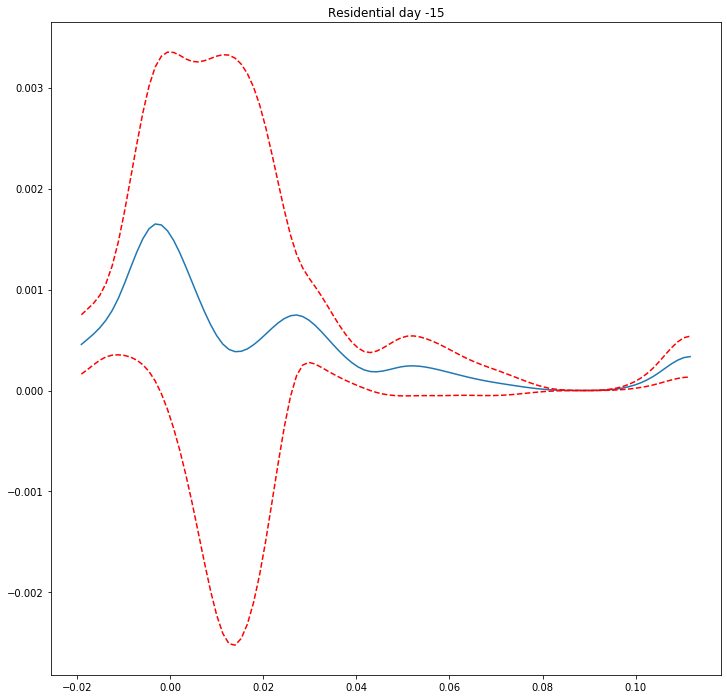

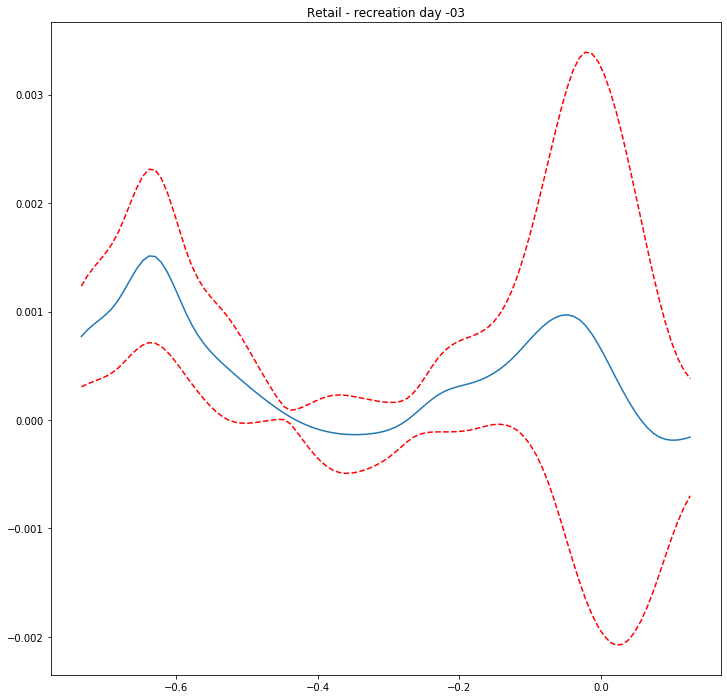

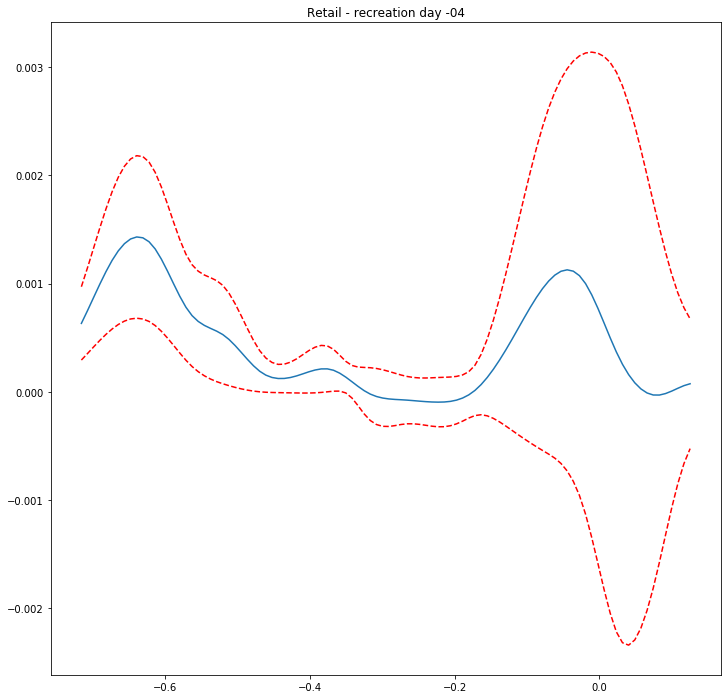

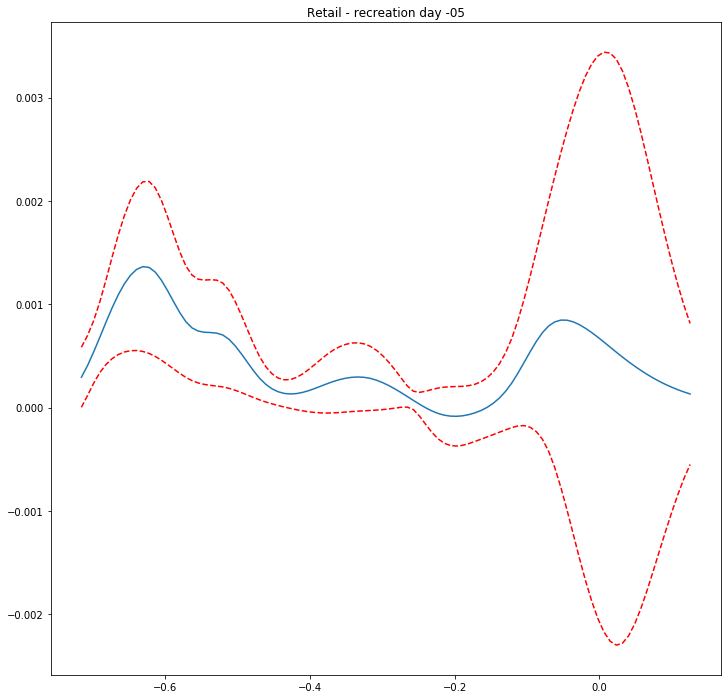

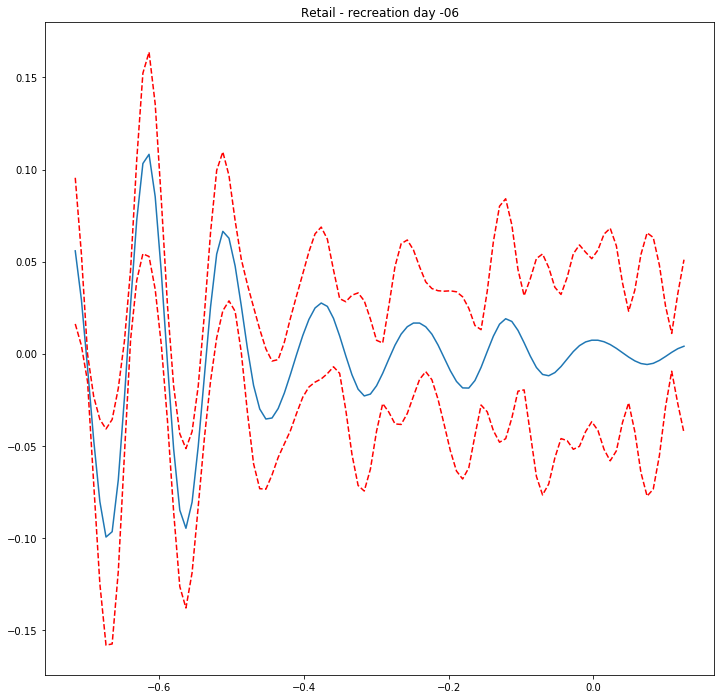

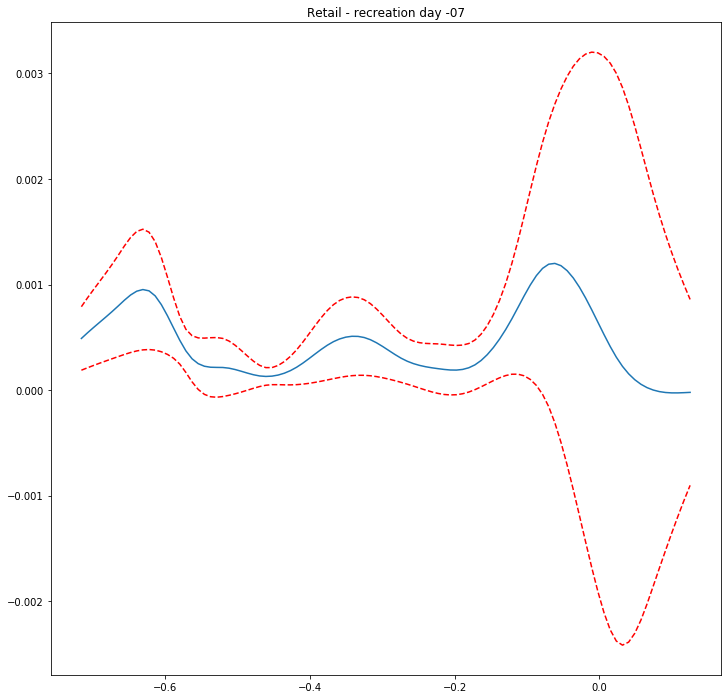

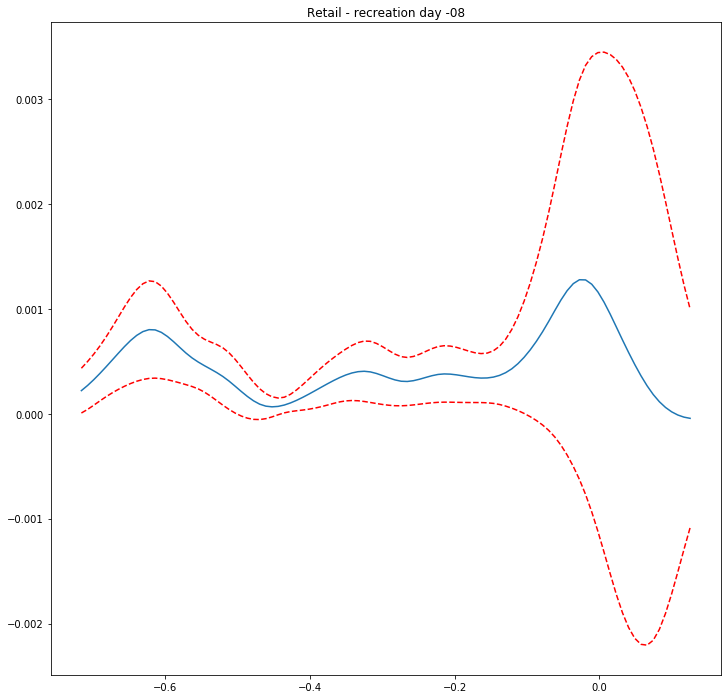

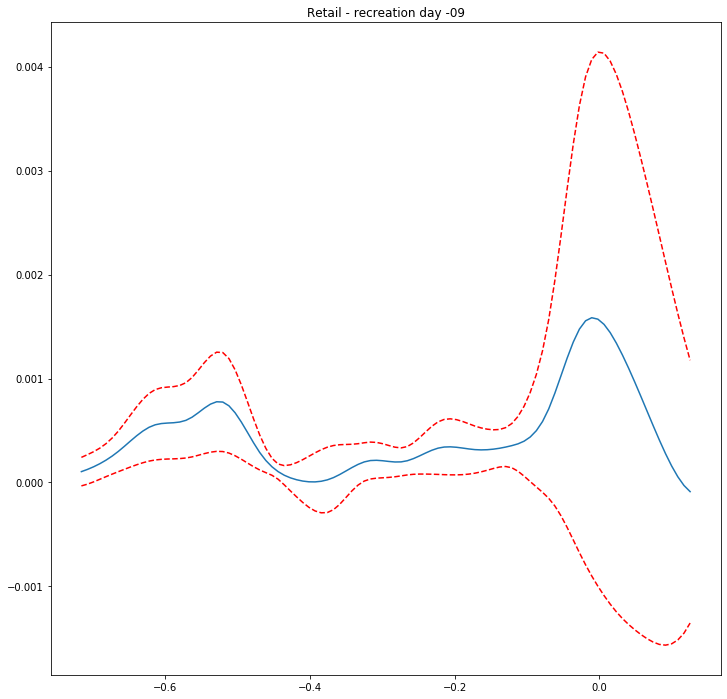

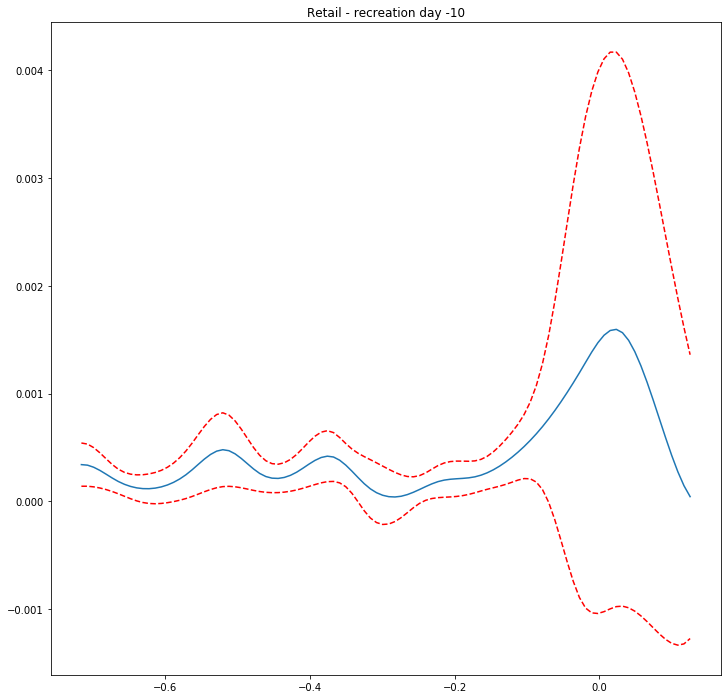

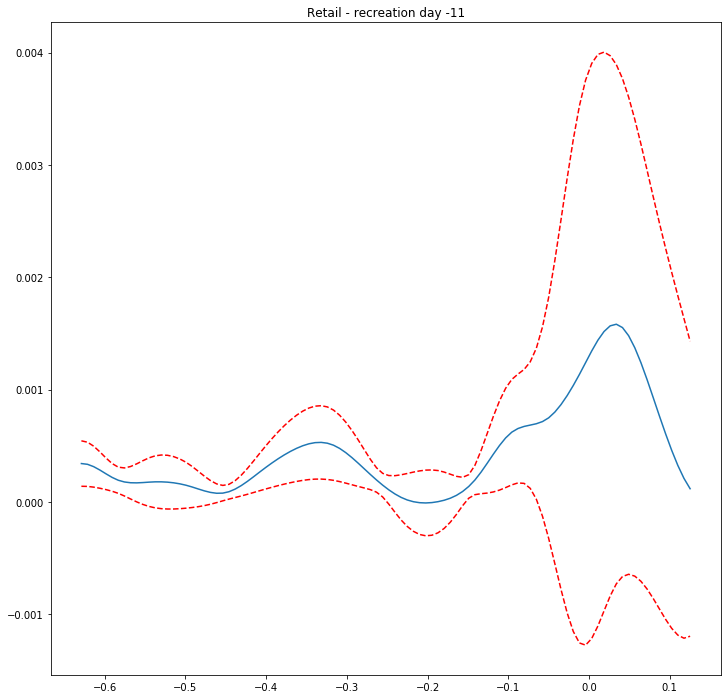

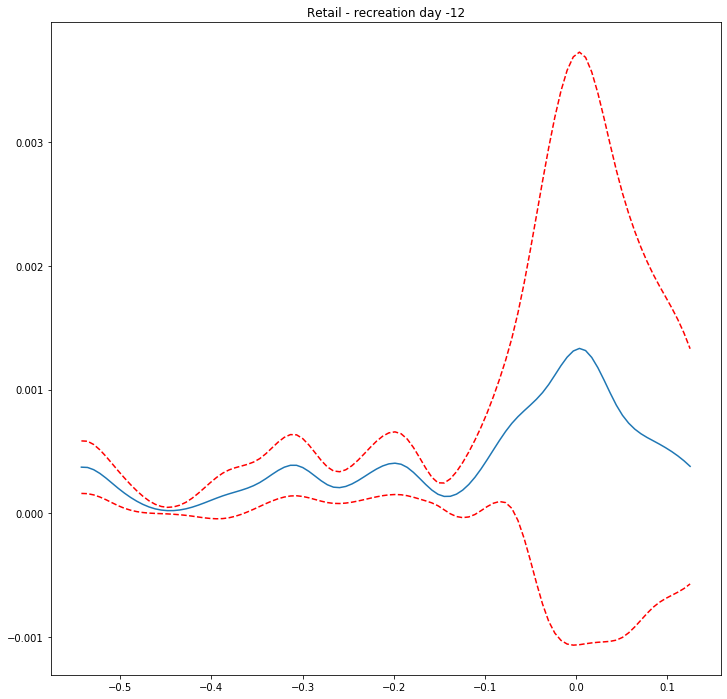

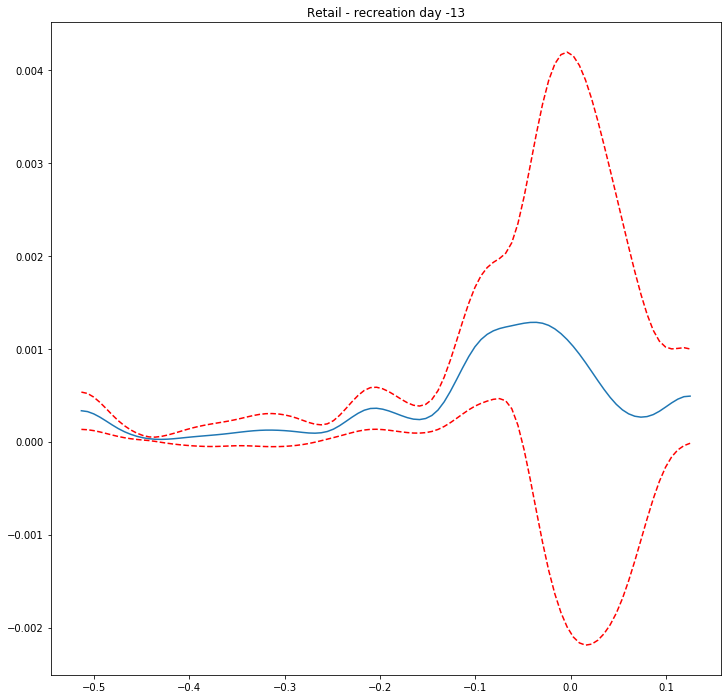

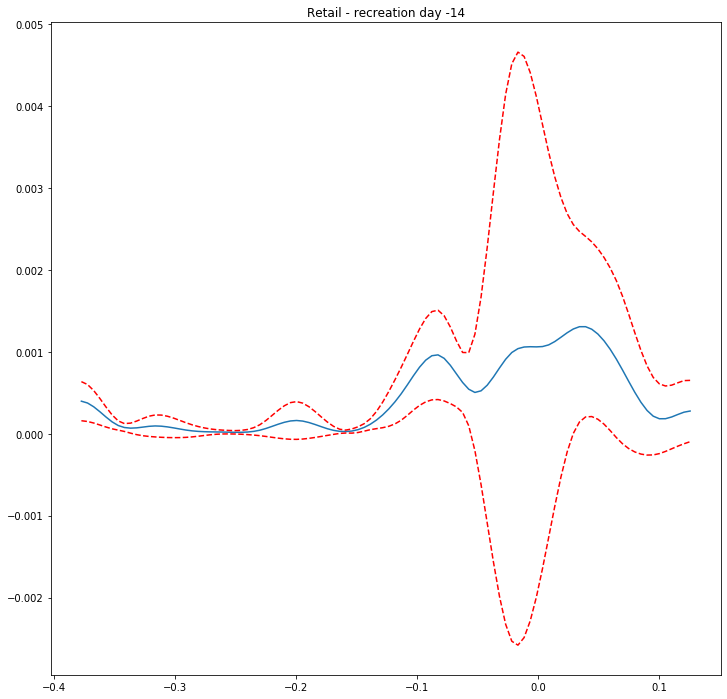

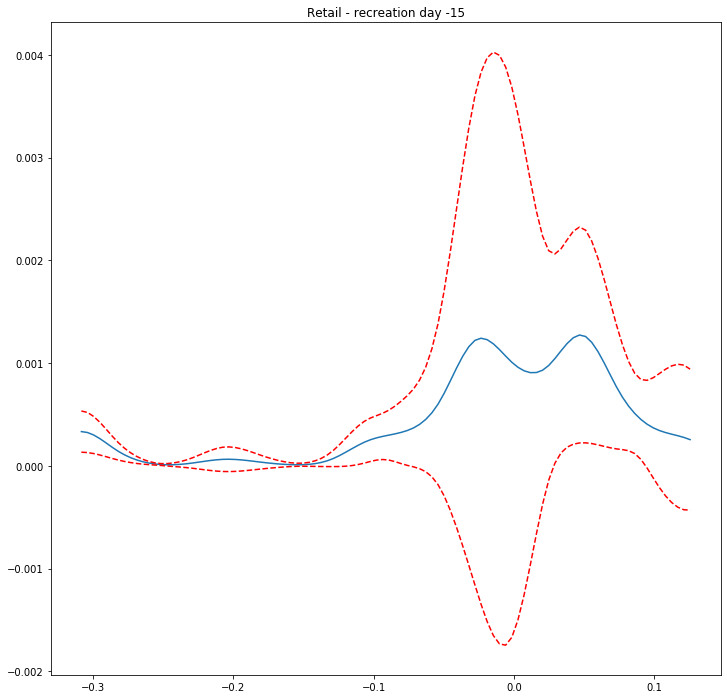

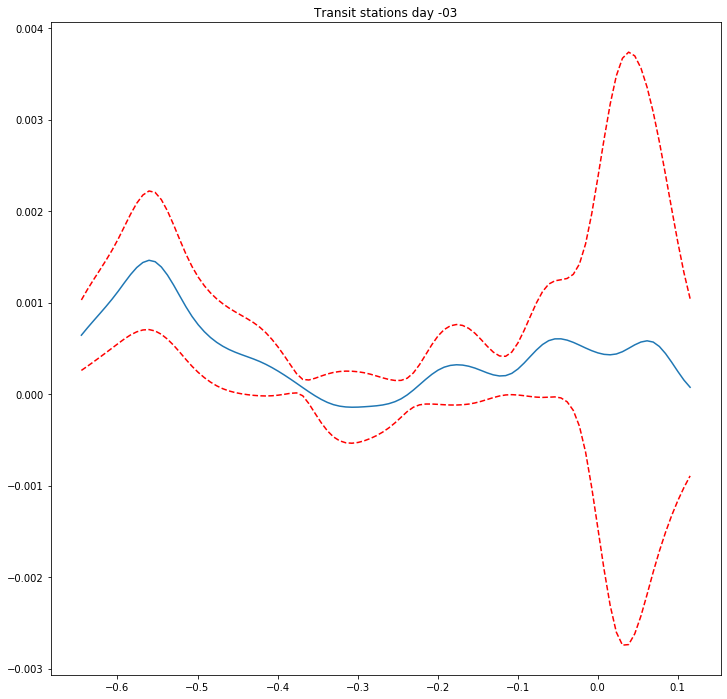

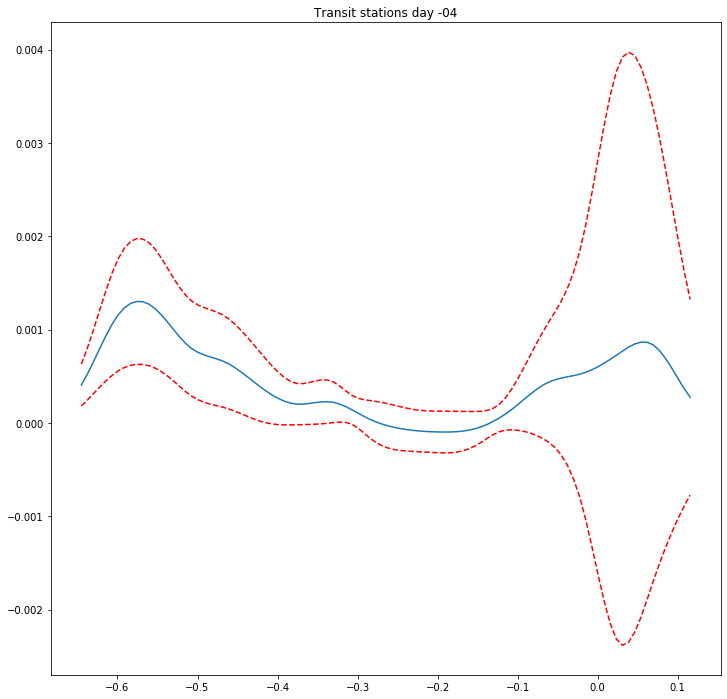

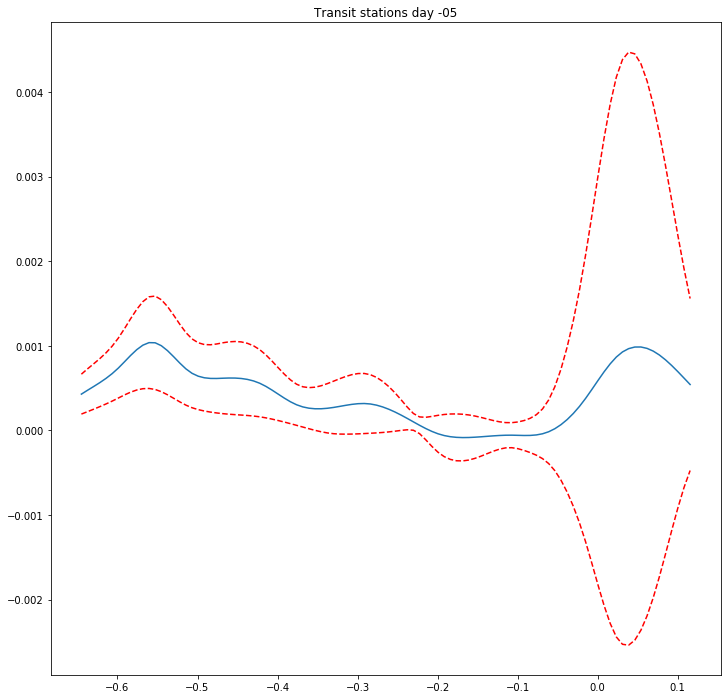

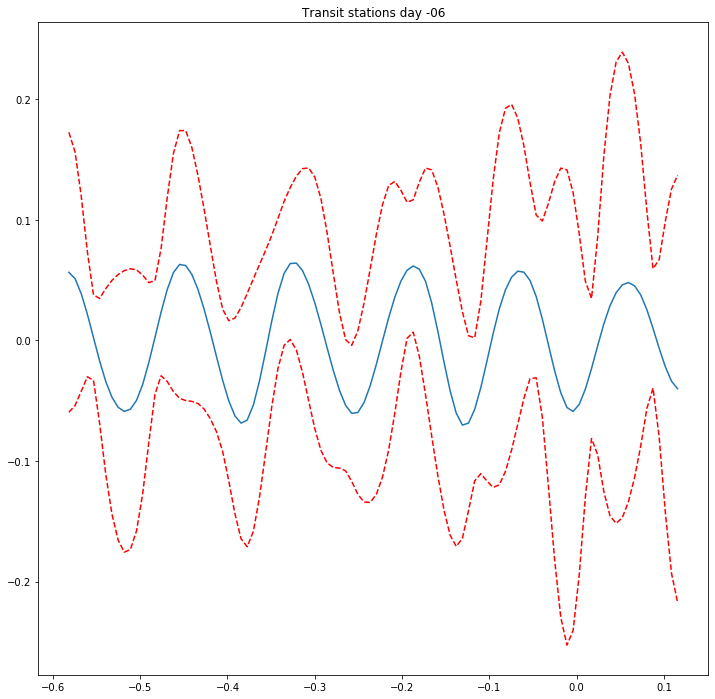

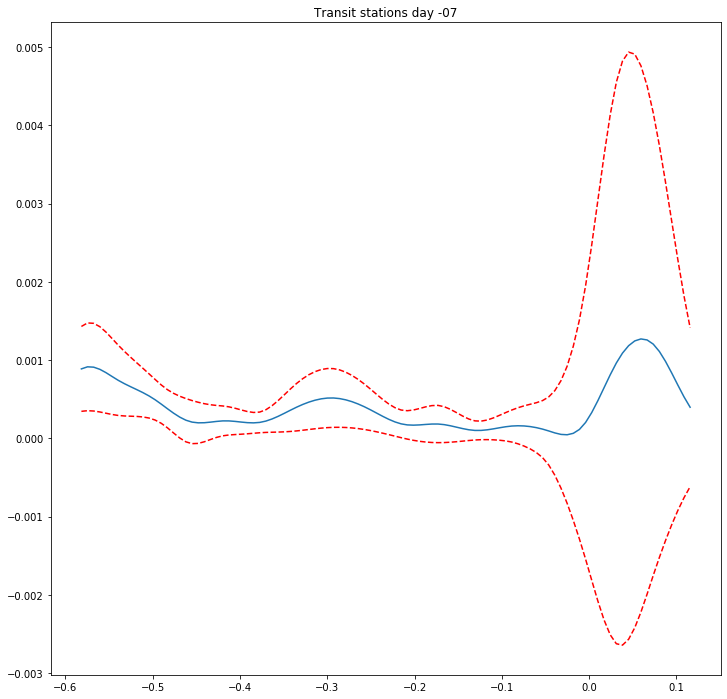

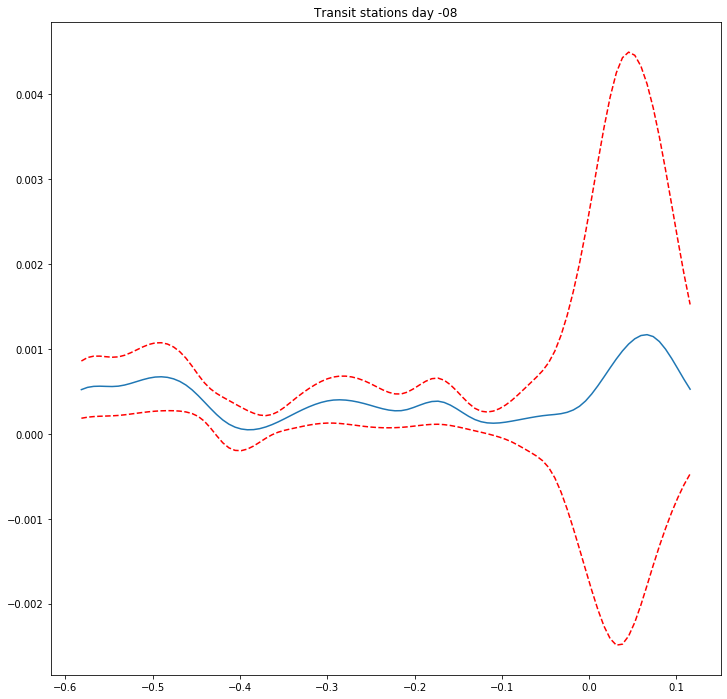

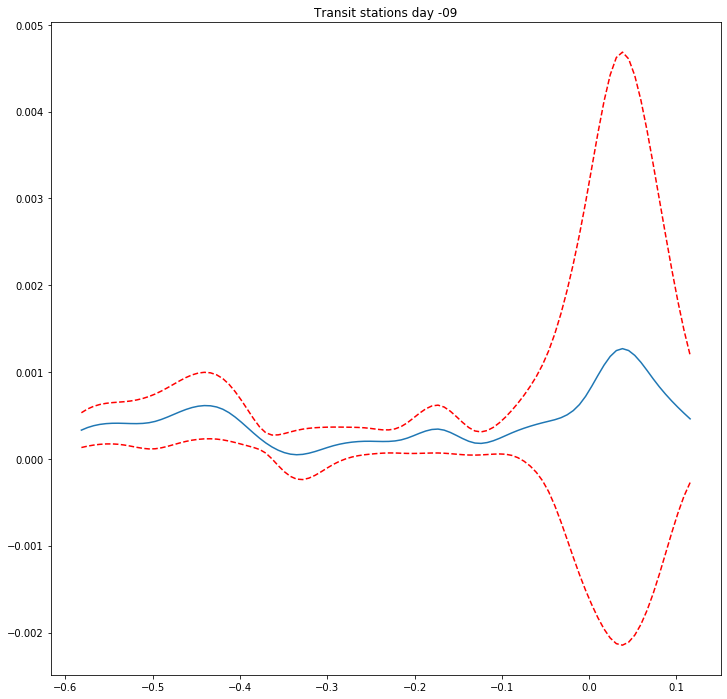

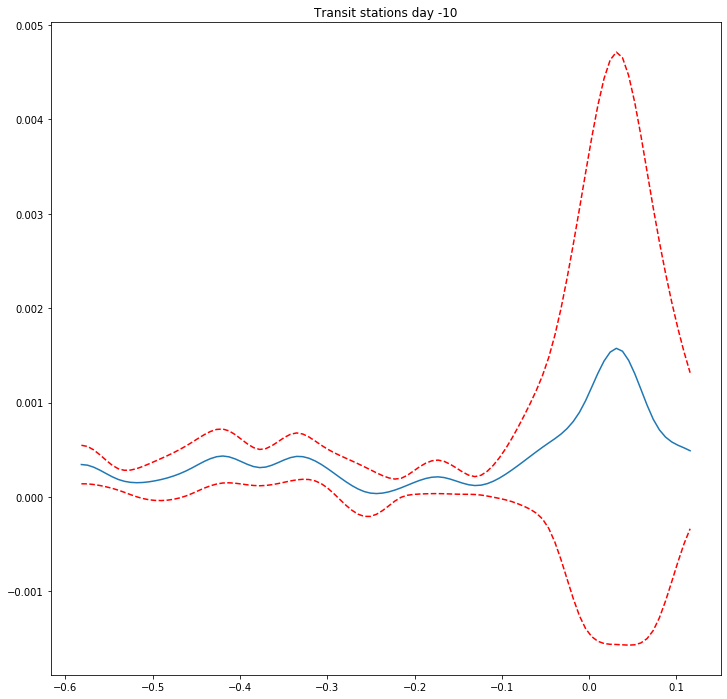

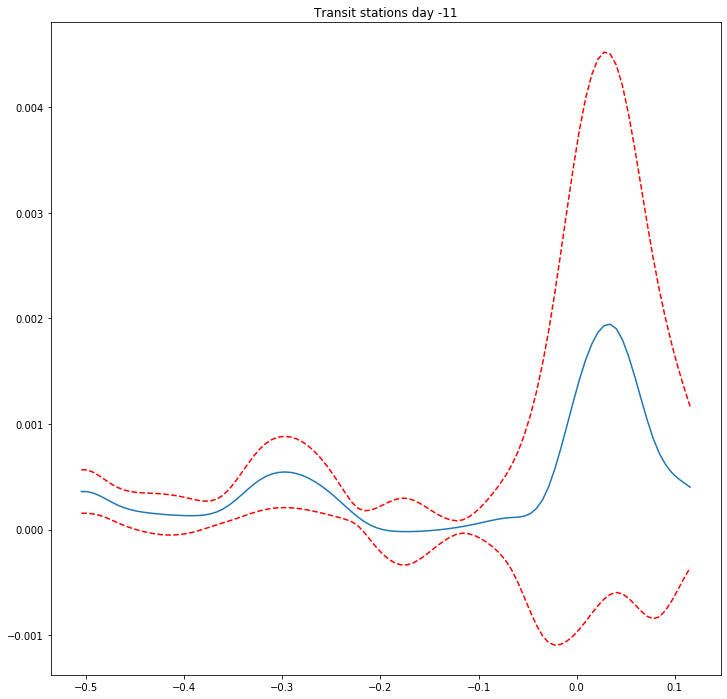

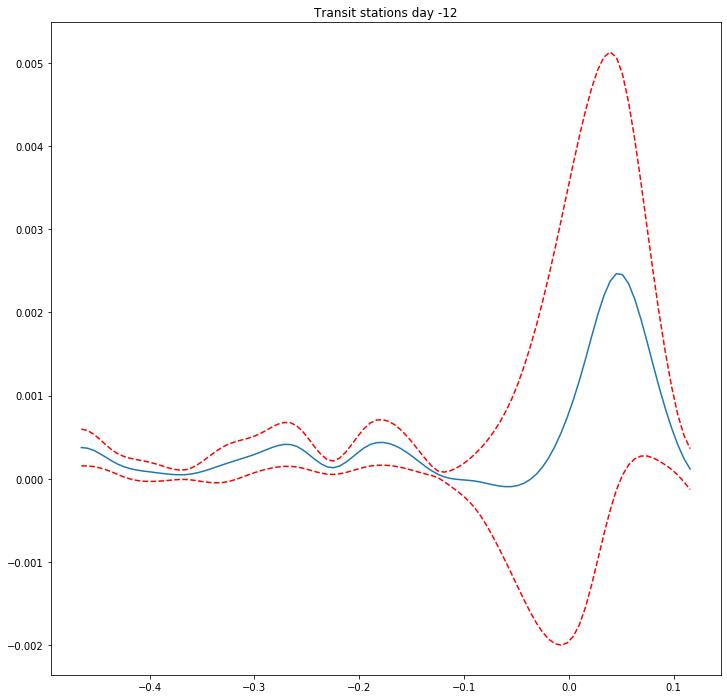

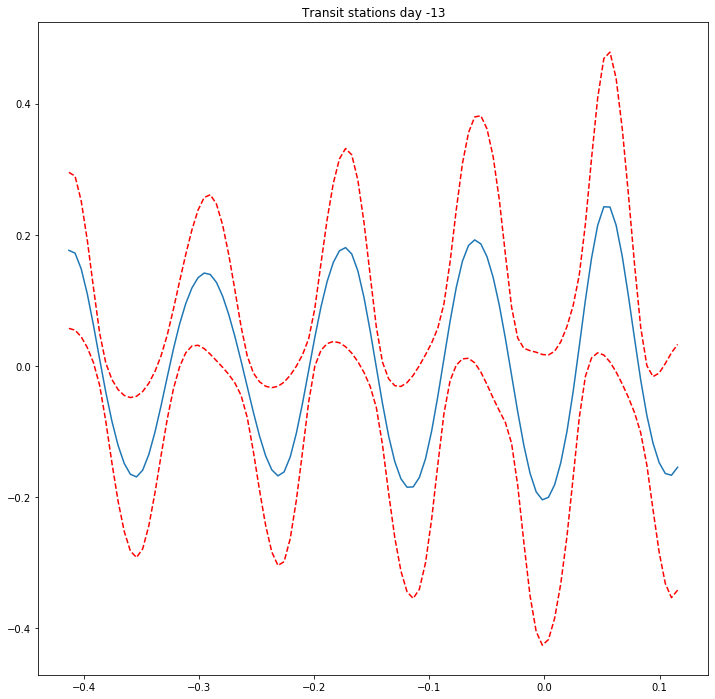

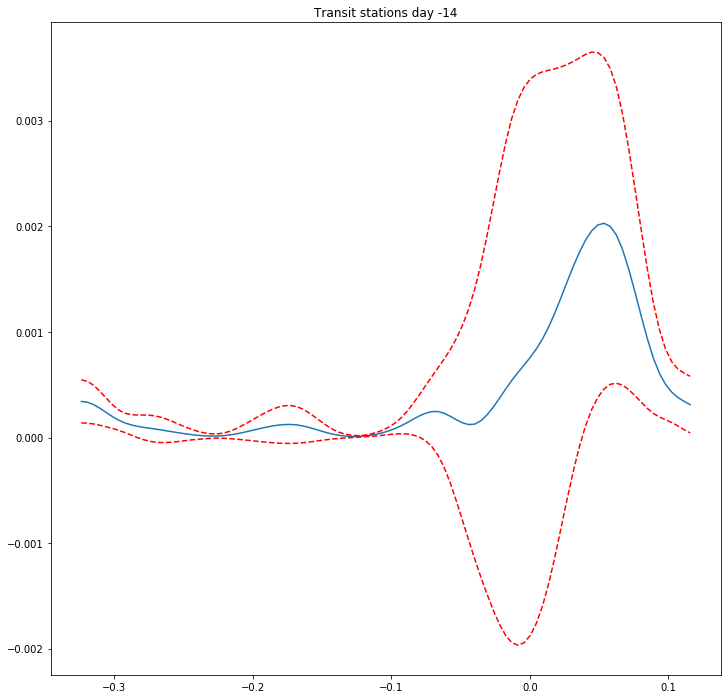

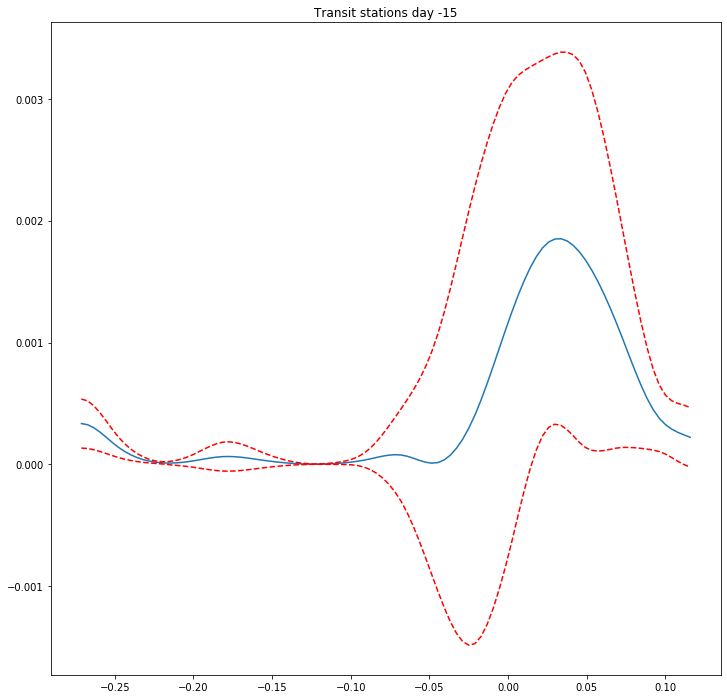

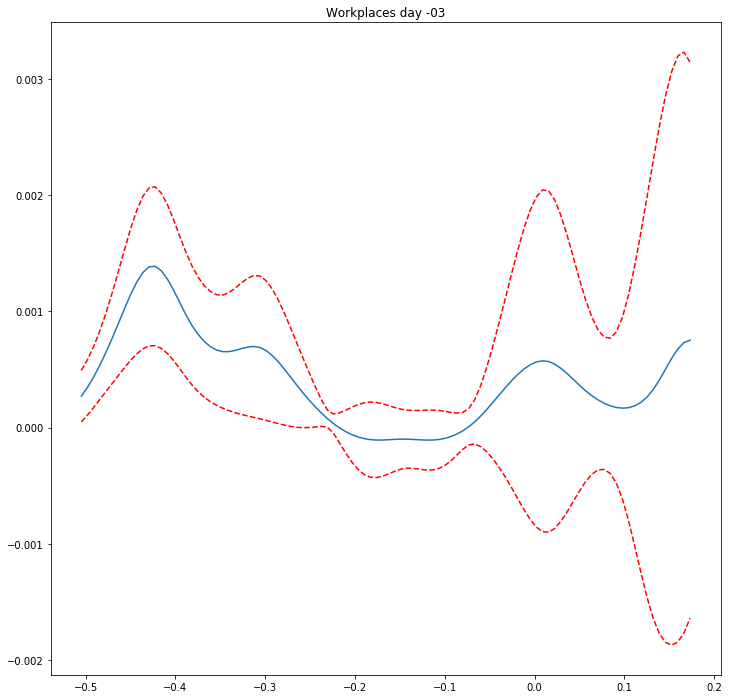

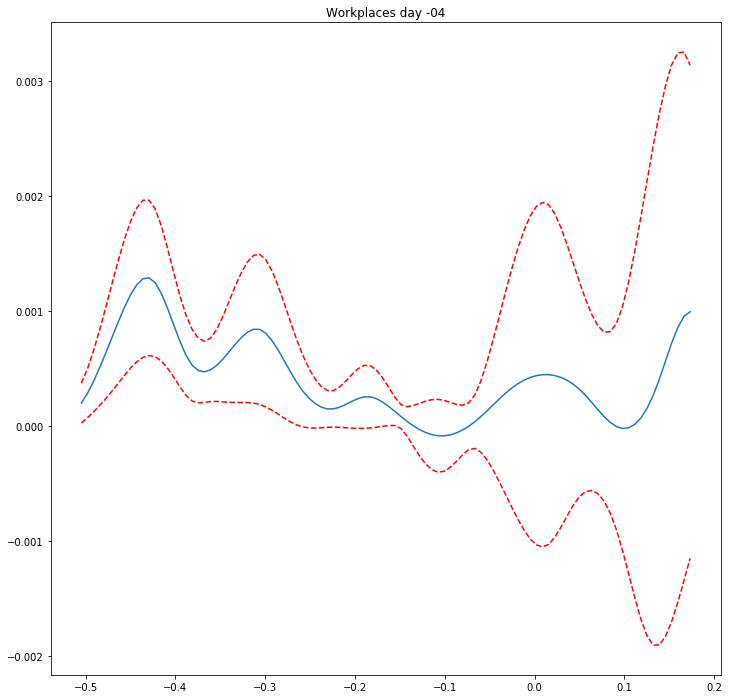

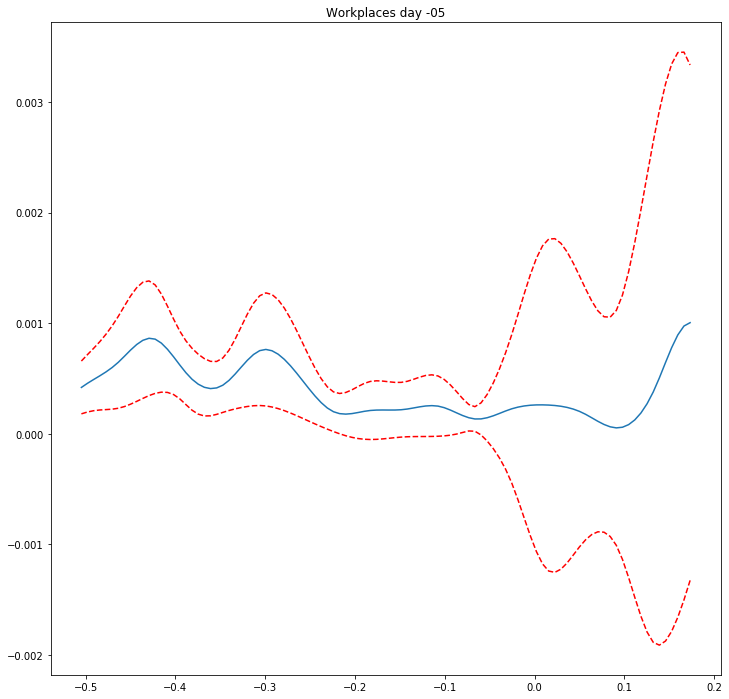

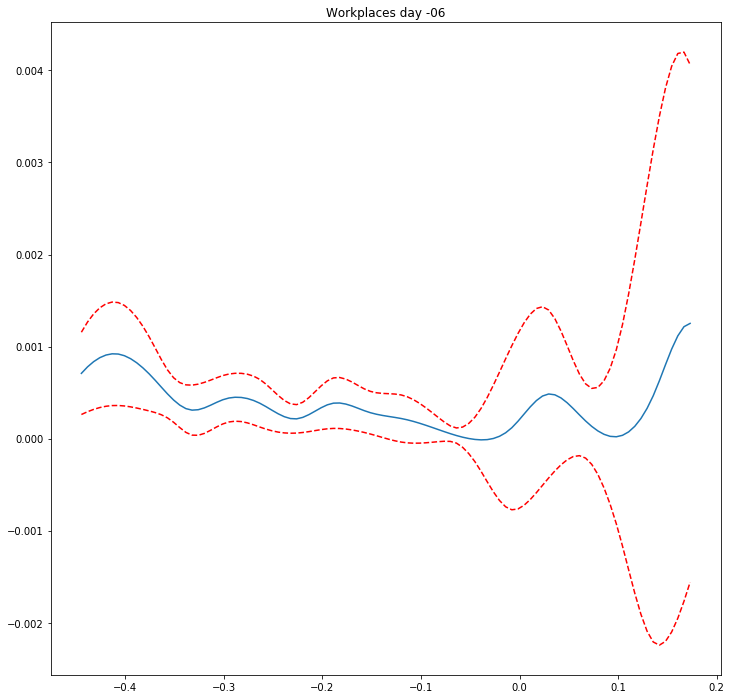

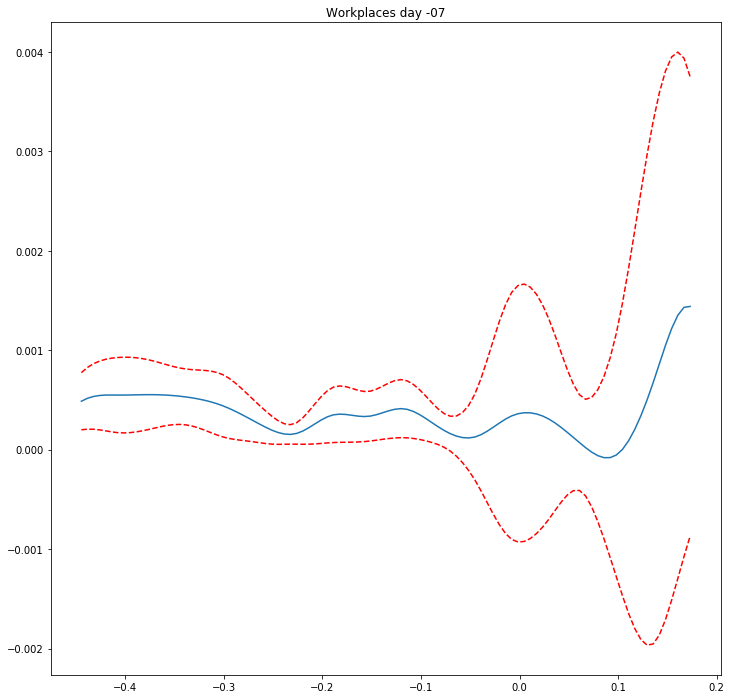

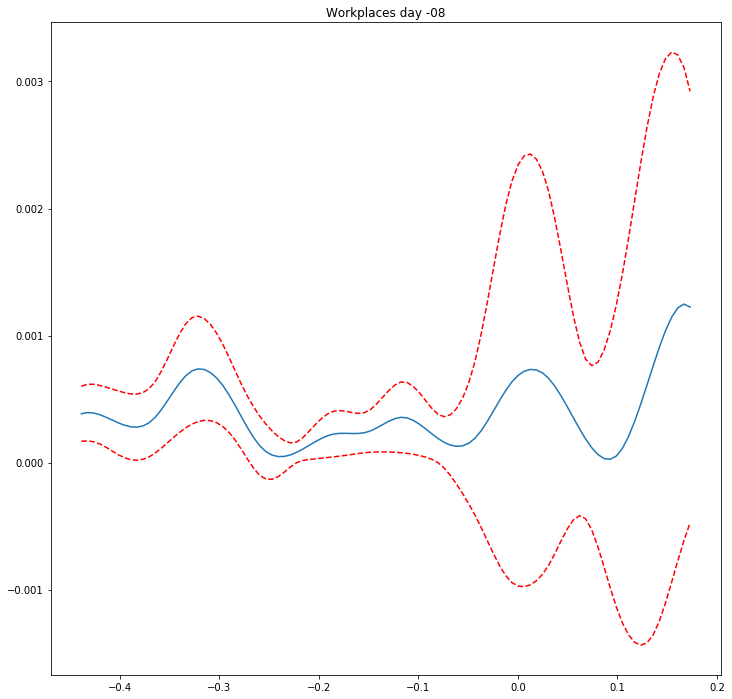

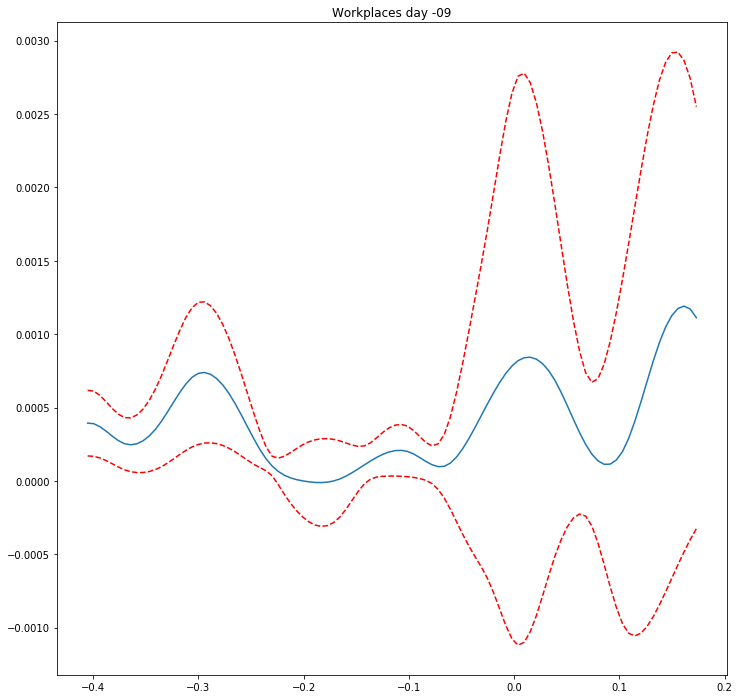

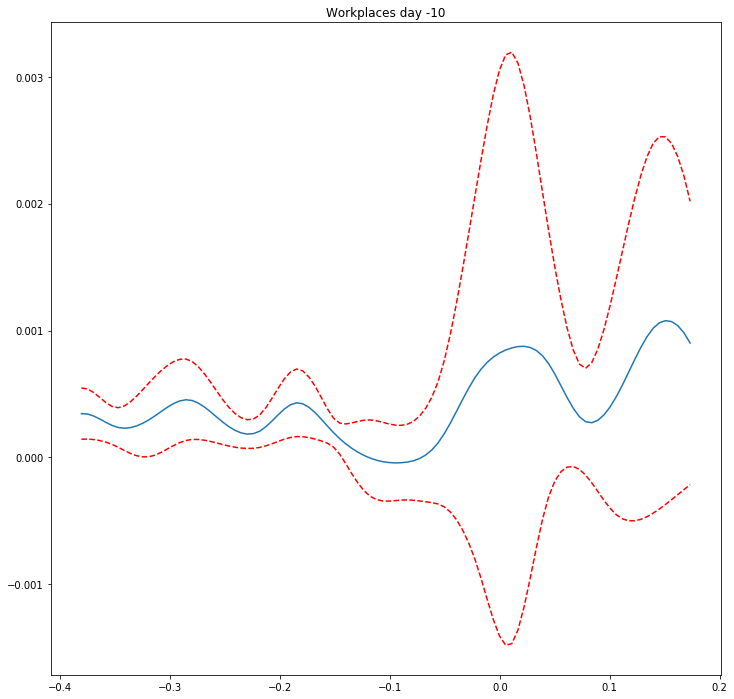

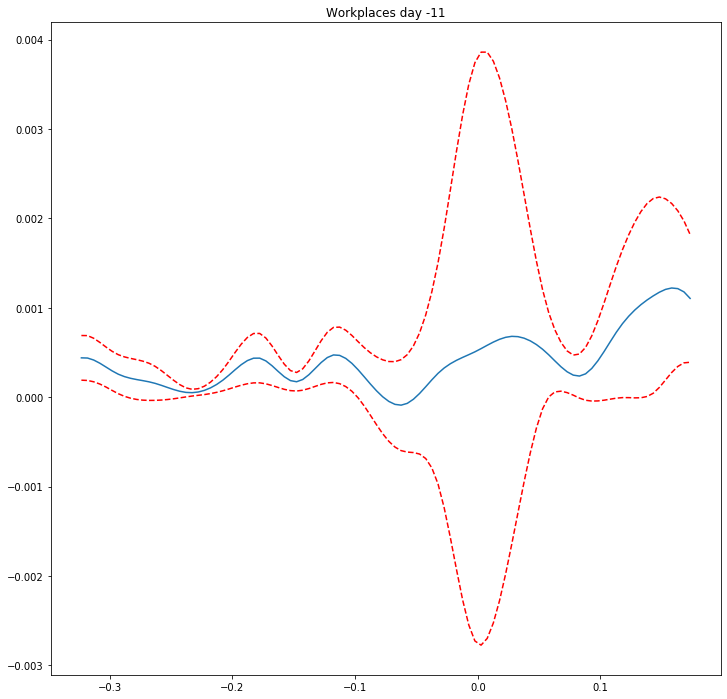

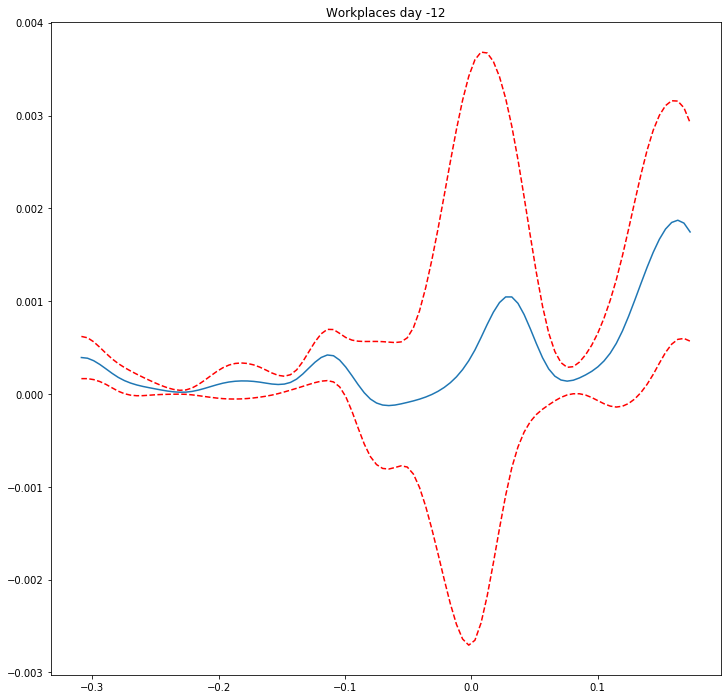

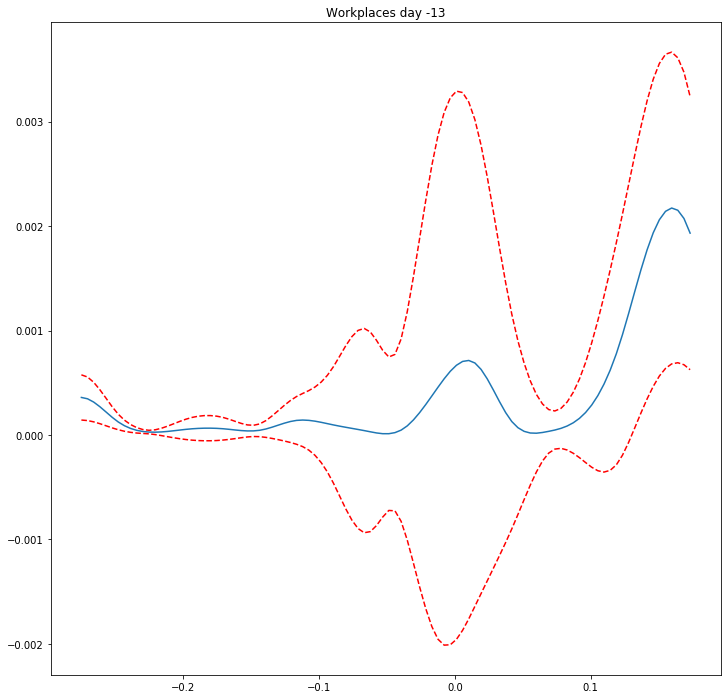

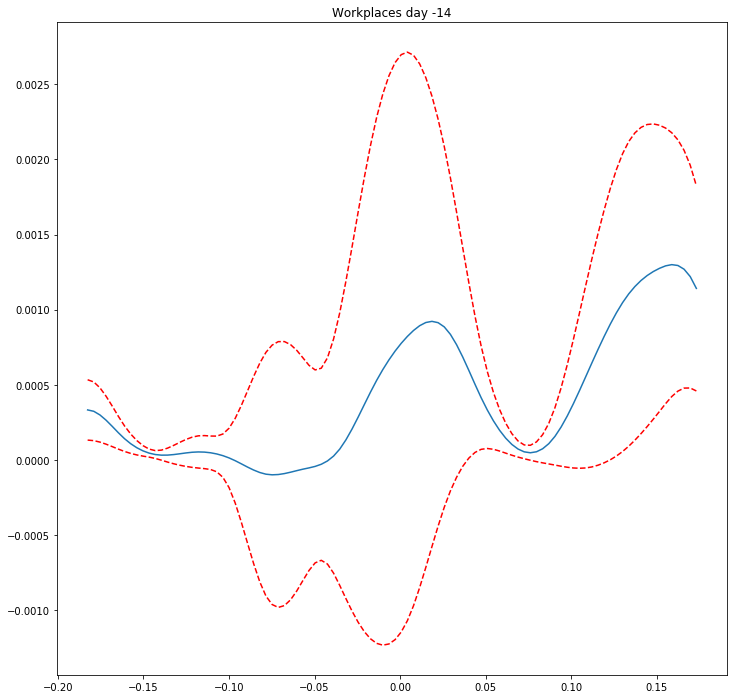

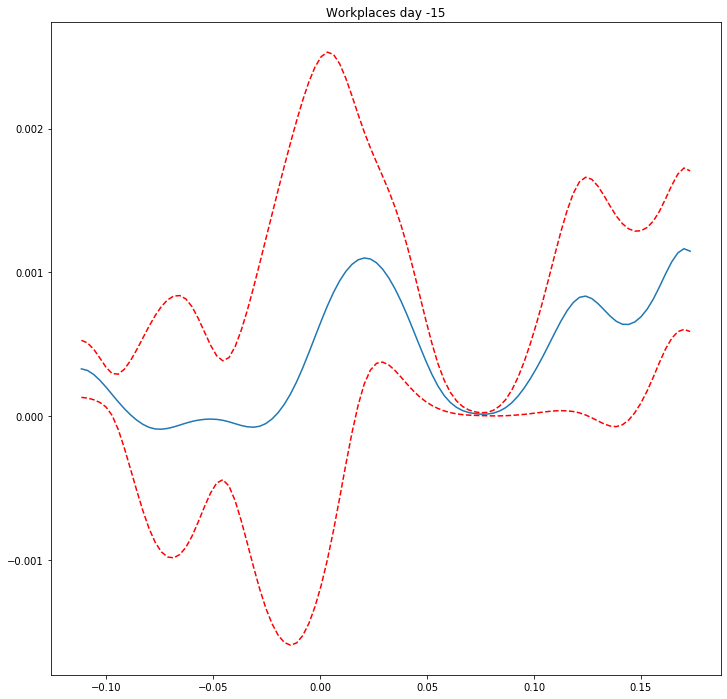

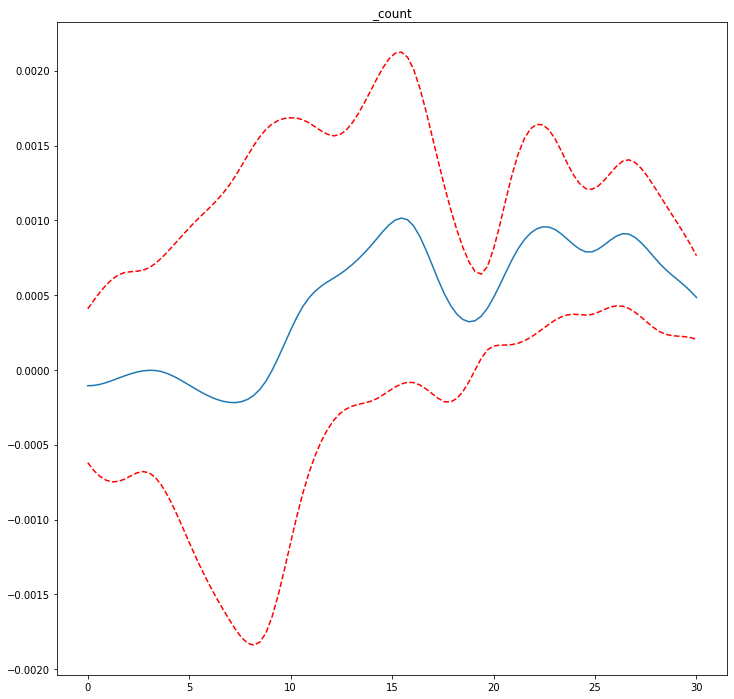

In [39]:
import matplotlib.pyplot as plt


for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(df.columns[i])
    plt.show()